In [1]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition
import os
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False 
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 

In [2]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
feature_calculators = MultipleFeaturizer([cf.ElementFraction(), cf.IonProperty(fast=True)])
if not os.path.exists('./data/dataset.csv'):
    data = pd.read_csv('./data/cation_replacement_features_pred.csv',index_col=0)
    if 'composition' not in data.columns:
        data['composition'] = data['formula'].map(Composition)
    data = feature_calculators.featurize_dataframe(data, col_id='composition');
    data = data.rename({'count':'number of elements'})
    data['is_doping'] = data['formula'].map(lambda x: 0 if sorted(Composition(x).as_dict().values())==[1.0,2.0,4.0] else 1)
    data['compound possible'] = data['compound possible'].map(lambda x: 1 if x else 0)
    data = data.drop(data.columns[data.eq(0).all()], axis=1)
    data.to_csv('./data/dataset.csv')
else:
    data = pd.read_csv('./data/dataset.csv',index_col=0)

In [3]:
#data = data[data['band gap']>=0.5].reset_index(drop=True)
data = data[data['band gap']>=0.5]
print(data.shape)
X = data.drop(columns=['formula','band gap','composition'])
y = data['band gap']

(35602, 108)


In [4]:
data.loc[119]

A_Density                      7.13
B_Density                     19.62
A_dipole Polarizability       38.67
B_dipole Polarizability        96.0
A_covalent Radius             118.0
                             ...   
Bi                         0.285714
compound possible                 1
max ionic char             0.551131
avg ionic char             0.111009
is_doping                         0
Name: 119, Length: 108, dtype: object

In [5]:
from scipy.stats import spearmanr
def remove_collinear_features(x, y,threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                x1 = x[col.values[0]]
                x2 = x[row.values[0]]
                corr1,p1 = spearmanr(x1, y)
                corr2,p2 = spearmanr(x2, y)
                if np.abs(corr1) < np.abs(corr2):
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])
    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

# Regression

In [6]:
from sklearn.model_selection import train_test_split
X = remove_collinear_features(X, y, 0.8)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)
print(X_train.shape,X_test.shape)

(28481, 73) (7121, 73)


In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
model = RandomForestRegressor(n_jobs=-1,random_state=42)
model.fit(X_train, y_train)
feature_importance=pd.DataFrame()
feature_importance['features'] = X.columns
feature_importance['feature_importances'] = model.feature_importances_
threshold = np.sort(feature_importance['feature_importances'].values)
score = []
n_features = []
cols = []
for i in tqdm(threshold):
    selector = SelectFromModel(model,threshold=i)
    X_embedded = selector.fit_transform(X_train, y_train)
    once = cross_val_score(model,X_embedded,y_train,cv=5,scoring="r2",n_jobs=-1).mean()#交叉验证
    score.append(once)
    n_features.append(X_embedded.shape[1])
    cols.append(X.columns[selector.get_support()])
result = pd.DataFrame({"col":cols,"score":score,"n_features":n_features})
result

100%|██████████| 73/73 [05:30<00:00,  4.53s/it]


col     score  n_features
0   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811411          73
1   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811310          72
2   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811327          71
3   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811465          70
4   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811373          69
..                                                ...       ...         ...
68  Index(['A_number of s+p Electrons', 'B_Mullike...  0.683492           5
69  Index(['B_Mulliken EN', '(A+B)-O_number of Val...  0.666111           4
70  Index(['B_Mulliken EN', '(A+B)-O_number of Val...  0.602256           3
71  Index(['B_Mulliken EN', '(A+B)-O_number of Val...  0.557969           2
72  Index(['(A+B)-O_number of Valence Electrons'],...  0.420899           1

[73 rows x 3 columns]

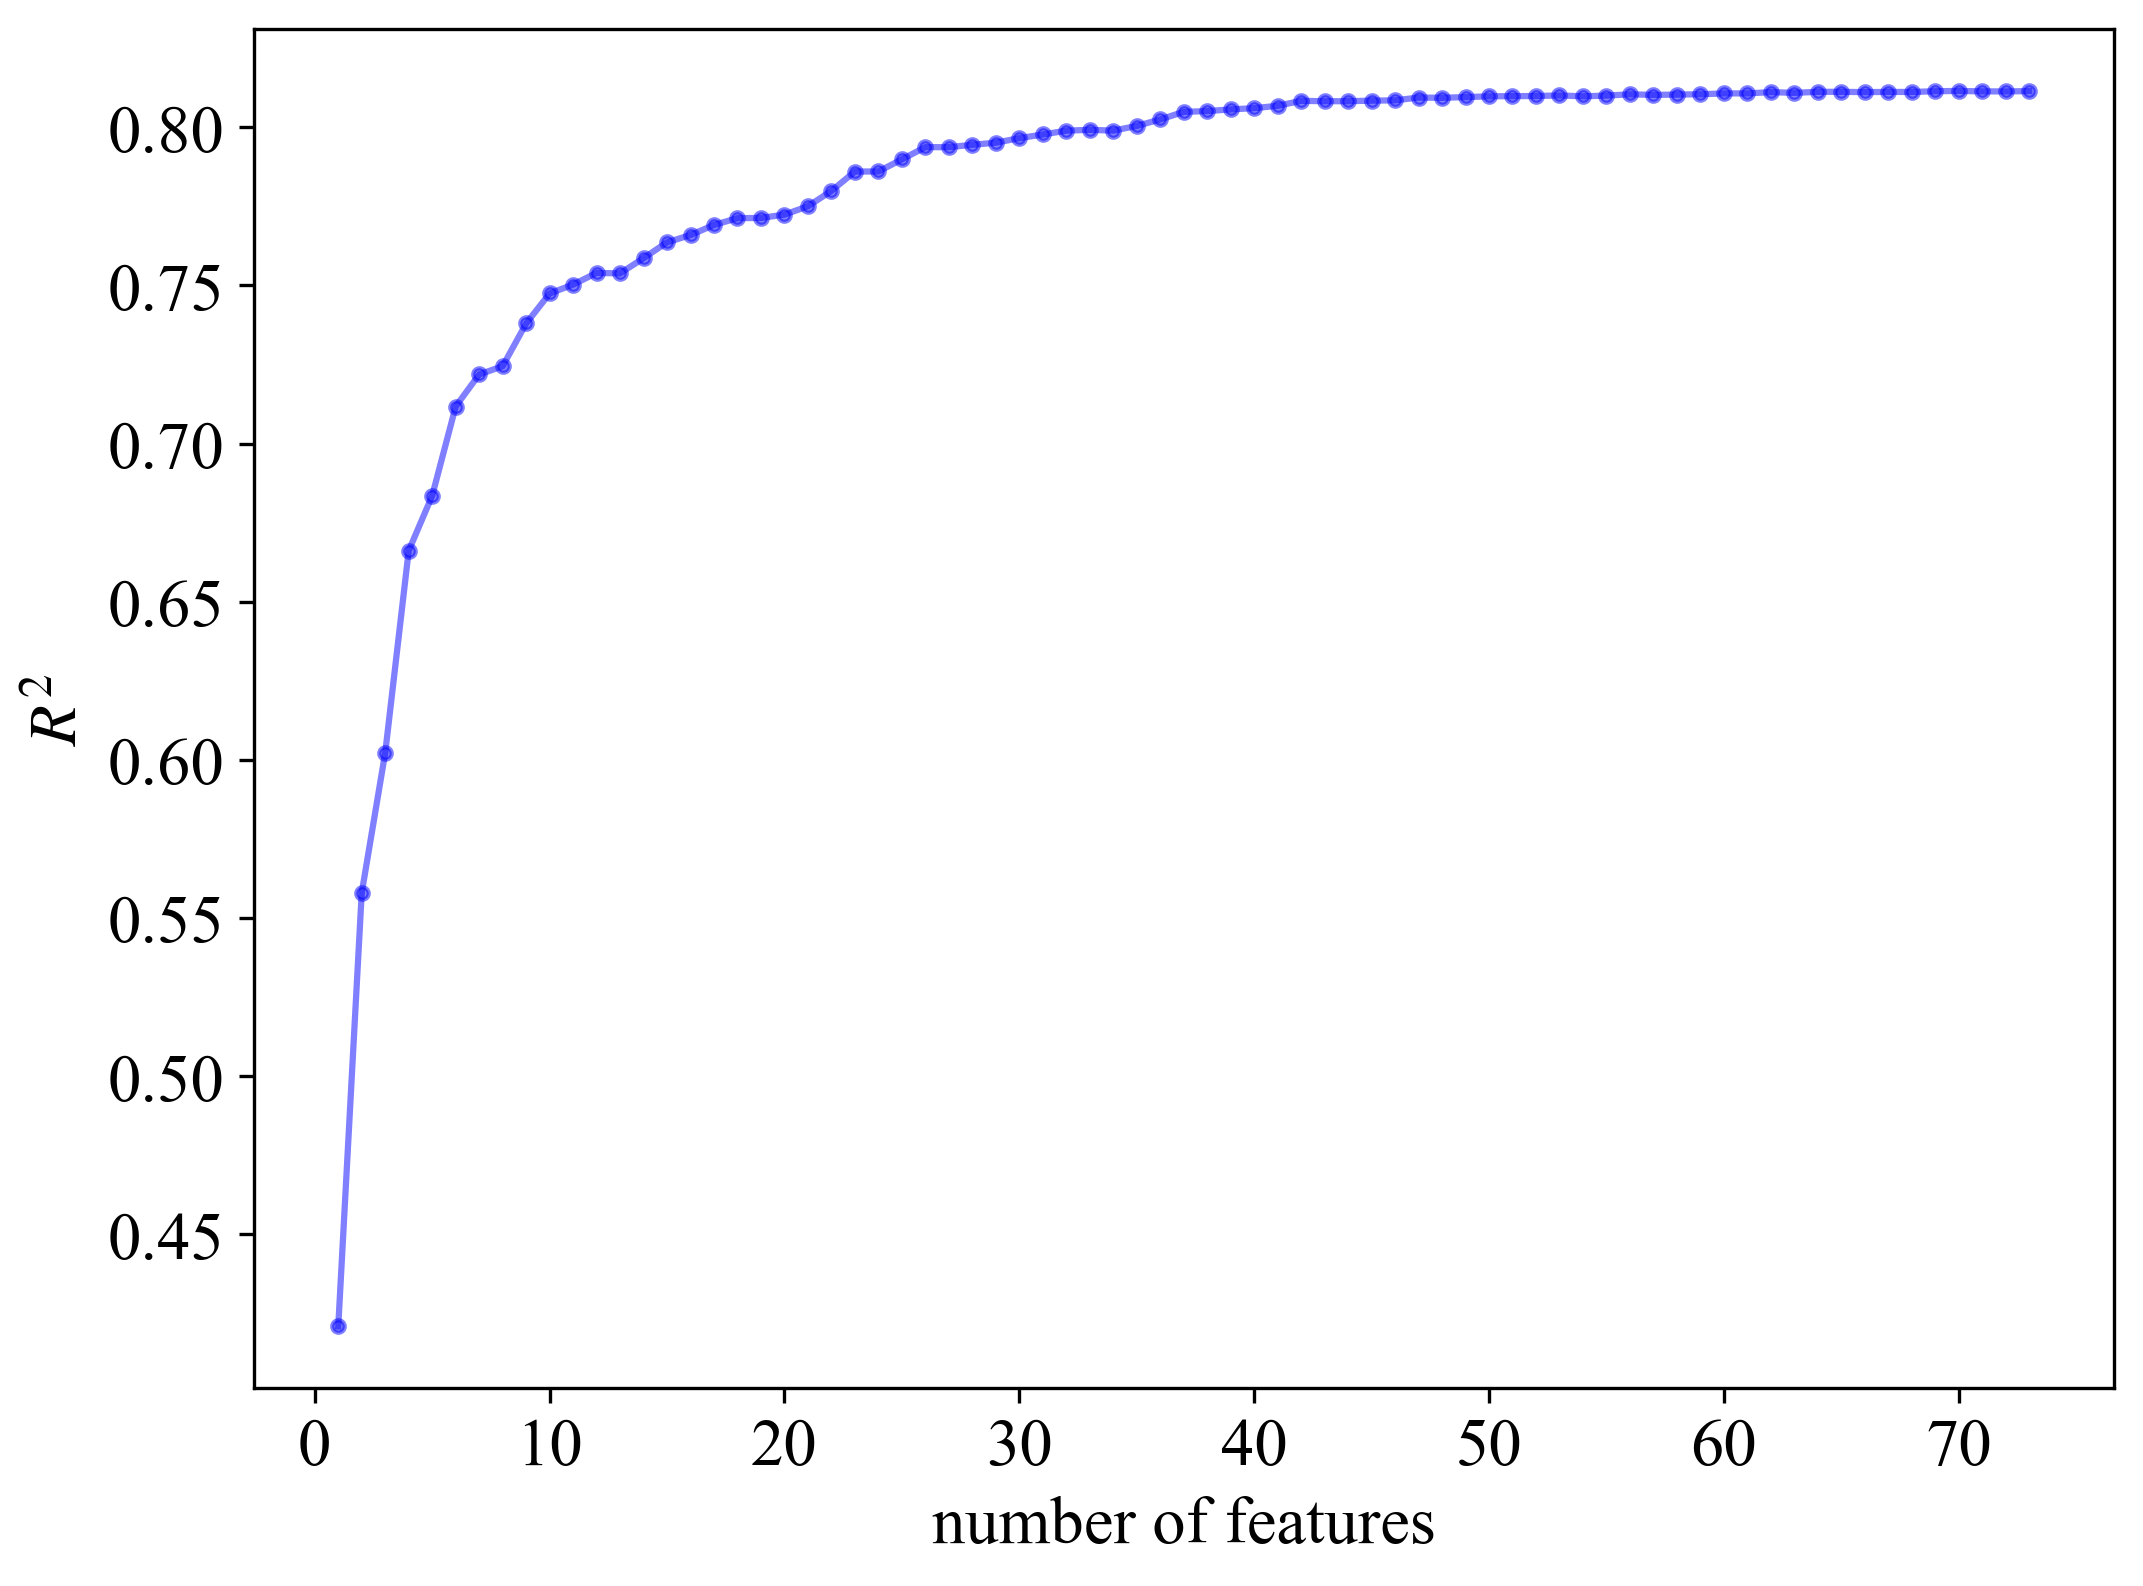

In [8]:
f_fig, f_ax = plt.subplots(figsize=(8, 6))
# to_select = result[result['score']>=0.8155]
to_select = result.sort_values(by='n_features',ascending=True)
# f_ax.scatter(to_select.iloc[0]['n_features'],to_select.iloc[0]['score'],marker='*',
#             s=50,c='r',label='best combination of features')
f_ax.plot(n_features,score, color='b',marker='.',alpha=0.5)
# plt.axhline(y=to_select.iloc[0]['score'],linestyle="--",color='grey')
# plt.axvline(x=to_select.iloc[0]['n_features'],linestyle="--",color='grey')
f_ax.set_xlabel("number of features"), plt.ylabel(r'$R^2$')
plt.show()

In [9]:
to_select

col     score  n_features
72  Index(['(A+B)-O_number of Valence Electrons'],...  0.420899           1
71  Index(['B_Mulliken EN', '(A+B)-O_number of Val...  0.557969           2
70  Index(['B_Mulliken EN', '(A+B)-O_number of Val...  0.602256           3
69  Index(['B_Mulliken EN', '(A+B)-O_number of Val...  0.666111           4
68  Index(['A_number of s+p Electrons', 'B_Mullike...  0.683492           5
..                                                ...       ...         ...
4   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811373          69
3   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811465          70
2   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811327          71
1   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811310          72
0   Index(['A_Density', 'B_Density', 'A_covalent R...  0.811411          73

[73 rows x 3 columns]

In [10]:
feature_labels = to_select.iloc[-1]['col']
X_train = X.loc[X_train.index][feature_labels]
X_test = X.loc[X_test.index][feature_labels]
if 'O' in X_train.columns:
    X_train = X_train.drop(columns='O')
    X_test = X_test.drop(columns='O')
X_train.shape, X_test.shape

((28481, 72), (7121, 72))

In [11]:
X_train.loc[119]

A_Density                          7.130000
B_Density                         19.620000
A_covalent Radius                118.000000
A_number of Valence Electrons     12.000000
A_Period                           4.000000
                                    ...    
Bi                                 0.285714
compound possible                  1.000000
max ionic char                     0.551131
avg ionic char                     0.111009
is_doping                          0.000000
Name: 119, Length: 72, dtype: float64

In [12]:
X_test.columns

Index(['A_Density', 'B_Density', 'A_covalent Radius',
       'A_number of Valence Electrons', 'A_Period', 'B_Period',
       'A_Electronegativity', 'A_number of s+p Electrons',
       'B_number of s+p Electrons', 'B_Mulliken EN', 'A-B_Density',
       '(A+B)-O_Density', 'A-B_covalent Radius',
       '(A+B)-O_number of Valence Electrons', 'A-B_Electronegativity',
       '(A+B)-O_number of s+p Electrons', 'A-B_number of d Electrons', 'Li',
       'Be', 'Na', 'Mg', 'Al', 'Si', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
       'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'Rb', 'Sr', 'Y', 'Zr', 'Mo', 'Rh',
       'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs', 'Ba', 'La', 'Pr', 'Nd', 'Pm',
       'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'W', 'Ir',
       'Hg', 'Bi', 'compound possible', 'max ionic char', 'avg ionic char',
       'is_doping'],
      dtype='object')

In [13]:
def get_latex_feature_names(data):
    name_dict = {"A_covalent Radius": r'$ A^{\mathrm{covalentRadius}}$',
                 'A_Density':r'$ A^{\mathrm{density}}$',
                 'B_Density':r'$ B^{\mathrm{density}}$',
                 'A_Period': r'$ A^{\mathrm{period}}$',
                 'B_Period': r'$ B^{\mathrm{period}}$',
                 'A_number of Valence Electrons':r'$ A^{\mathrm{valenceElectrons}}$',
                 'B_number of Valence Electrons':r'$ B^{\mathrm{valenceElectrons}}$',
                 'A_Electronegativity':r'$ A^{\mathrm{Electronegativity}}$',
                 'B_Electronegativity':r'$ B^{\mathrm{Electronegativity}}$',
                 'B_Mulliken EN':r'$ B^{\mathrm{MullikenEN}}$',
                'A_number of s+p Electrons': r'$ A^{\mathrm{s+p}}$',
                'B_number of s+p Electrons': r'$ B^{\mathrm{s+p}}$',
                 'A-B_Density':r'$ X_\mathrm{1}^{\mathrm{density}}$',
                '(A+B)-O_Density': r'$ X_\mathrm{2}^{\mathrm{density}}$',
                 '(A+B)-O_covalent Radius':r'$ X_\mathrm{2}^{\mathrm{covalentRadius}}$',
                 'A-B_covalent Radius':r'$ X_\mathrm{1}^{\mathrm{covalentRadius}}$',
                 '(A+B)-O_number of Valence Electrons':r'$ X_\mathrm{2}^{\mathrm{valenceElectrons}}$',
                 'A-B_Electronegativity':r'$ X_\mathrm{1}^{\mathrm{electronegativity}}$',
                 'A-B_number of Valence Electrons':r'$ X_\mathrm{1}^{\mathrm{valenceElectrons}}$',
                 'A-B_number':r'$ X_\mathrm{1}^{\mathrm{number}}$',
                 '(A+B)-O_Electronegativity':r'$ X_\mathrm{2}^{\mathrm{electronegativity}}$',
                 'A-B_number of d Electrons':r'$X_\mathrm{1}^{\mathrm{d}}$',
                 'A-B_number of s+p Electrons':r'$ X_\mathrm{1}^{\mathrm{s+p}}$',
                 '(A+B)-O_number of s+p Electrons':r'$ X_\mathrm{2}^{\mathrm{s+p}}$',
                  '(A+B)-O_number of d Electrons':r'$ X_\mathrm{2}^{\mathrm{d}}$',
                }
    element_dict = {}
    for name in data.columns:
        if '_' not in name and len(name)<=2 :
            element_dict[name] = fr'${name}$'
    name_dict.update(element_dict)
    data = data.rename(columns=name_dict)
    return data

In [14]:
X_train = get_latex_feature_names(X_train)
X_test = get_latex_feature_names(X_test)

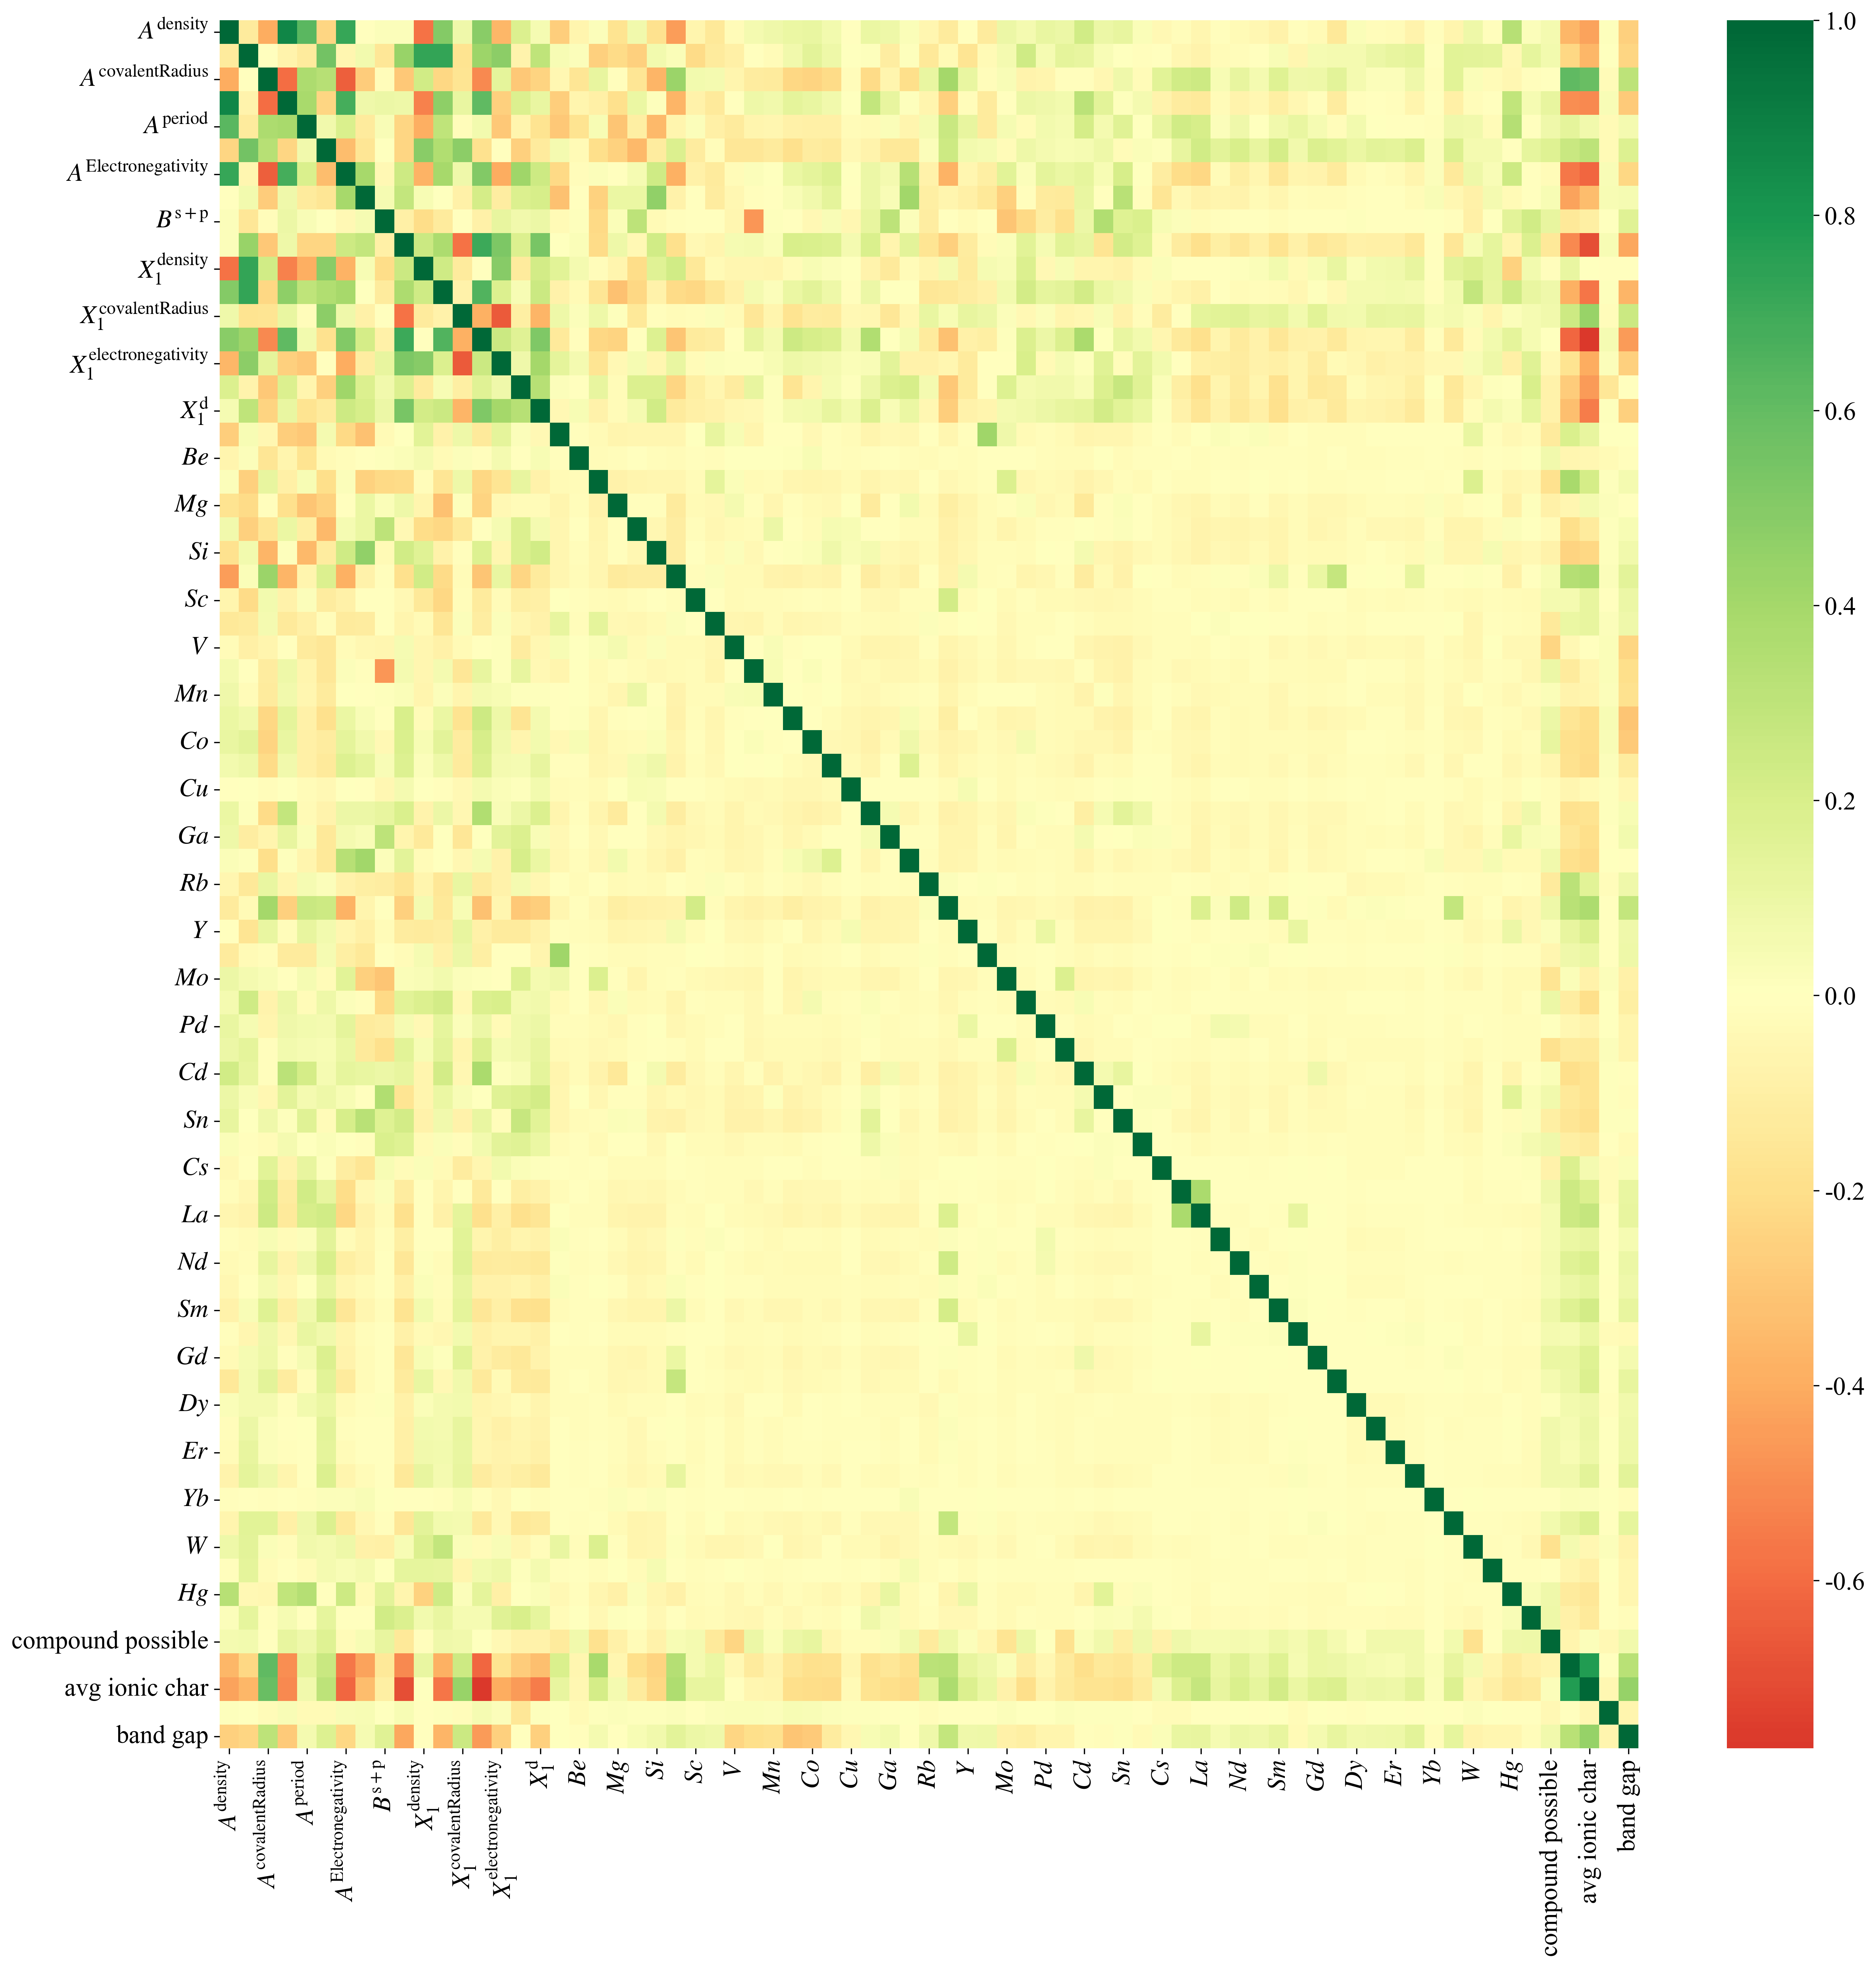

In [15]:
plt.figure(figsize=(20,20), dpi= 300)
sns.heatmap(pd.concat([X_train,y_train],axis=1).corr(method='spearman' ,min_periods=1), 
            cmap='RdYlGn', center=0, annot=False)
plt.show()

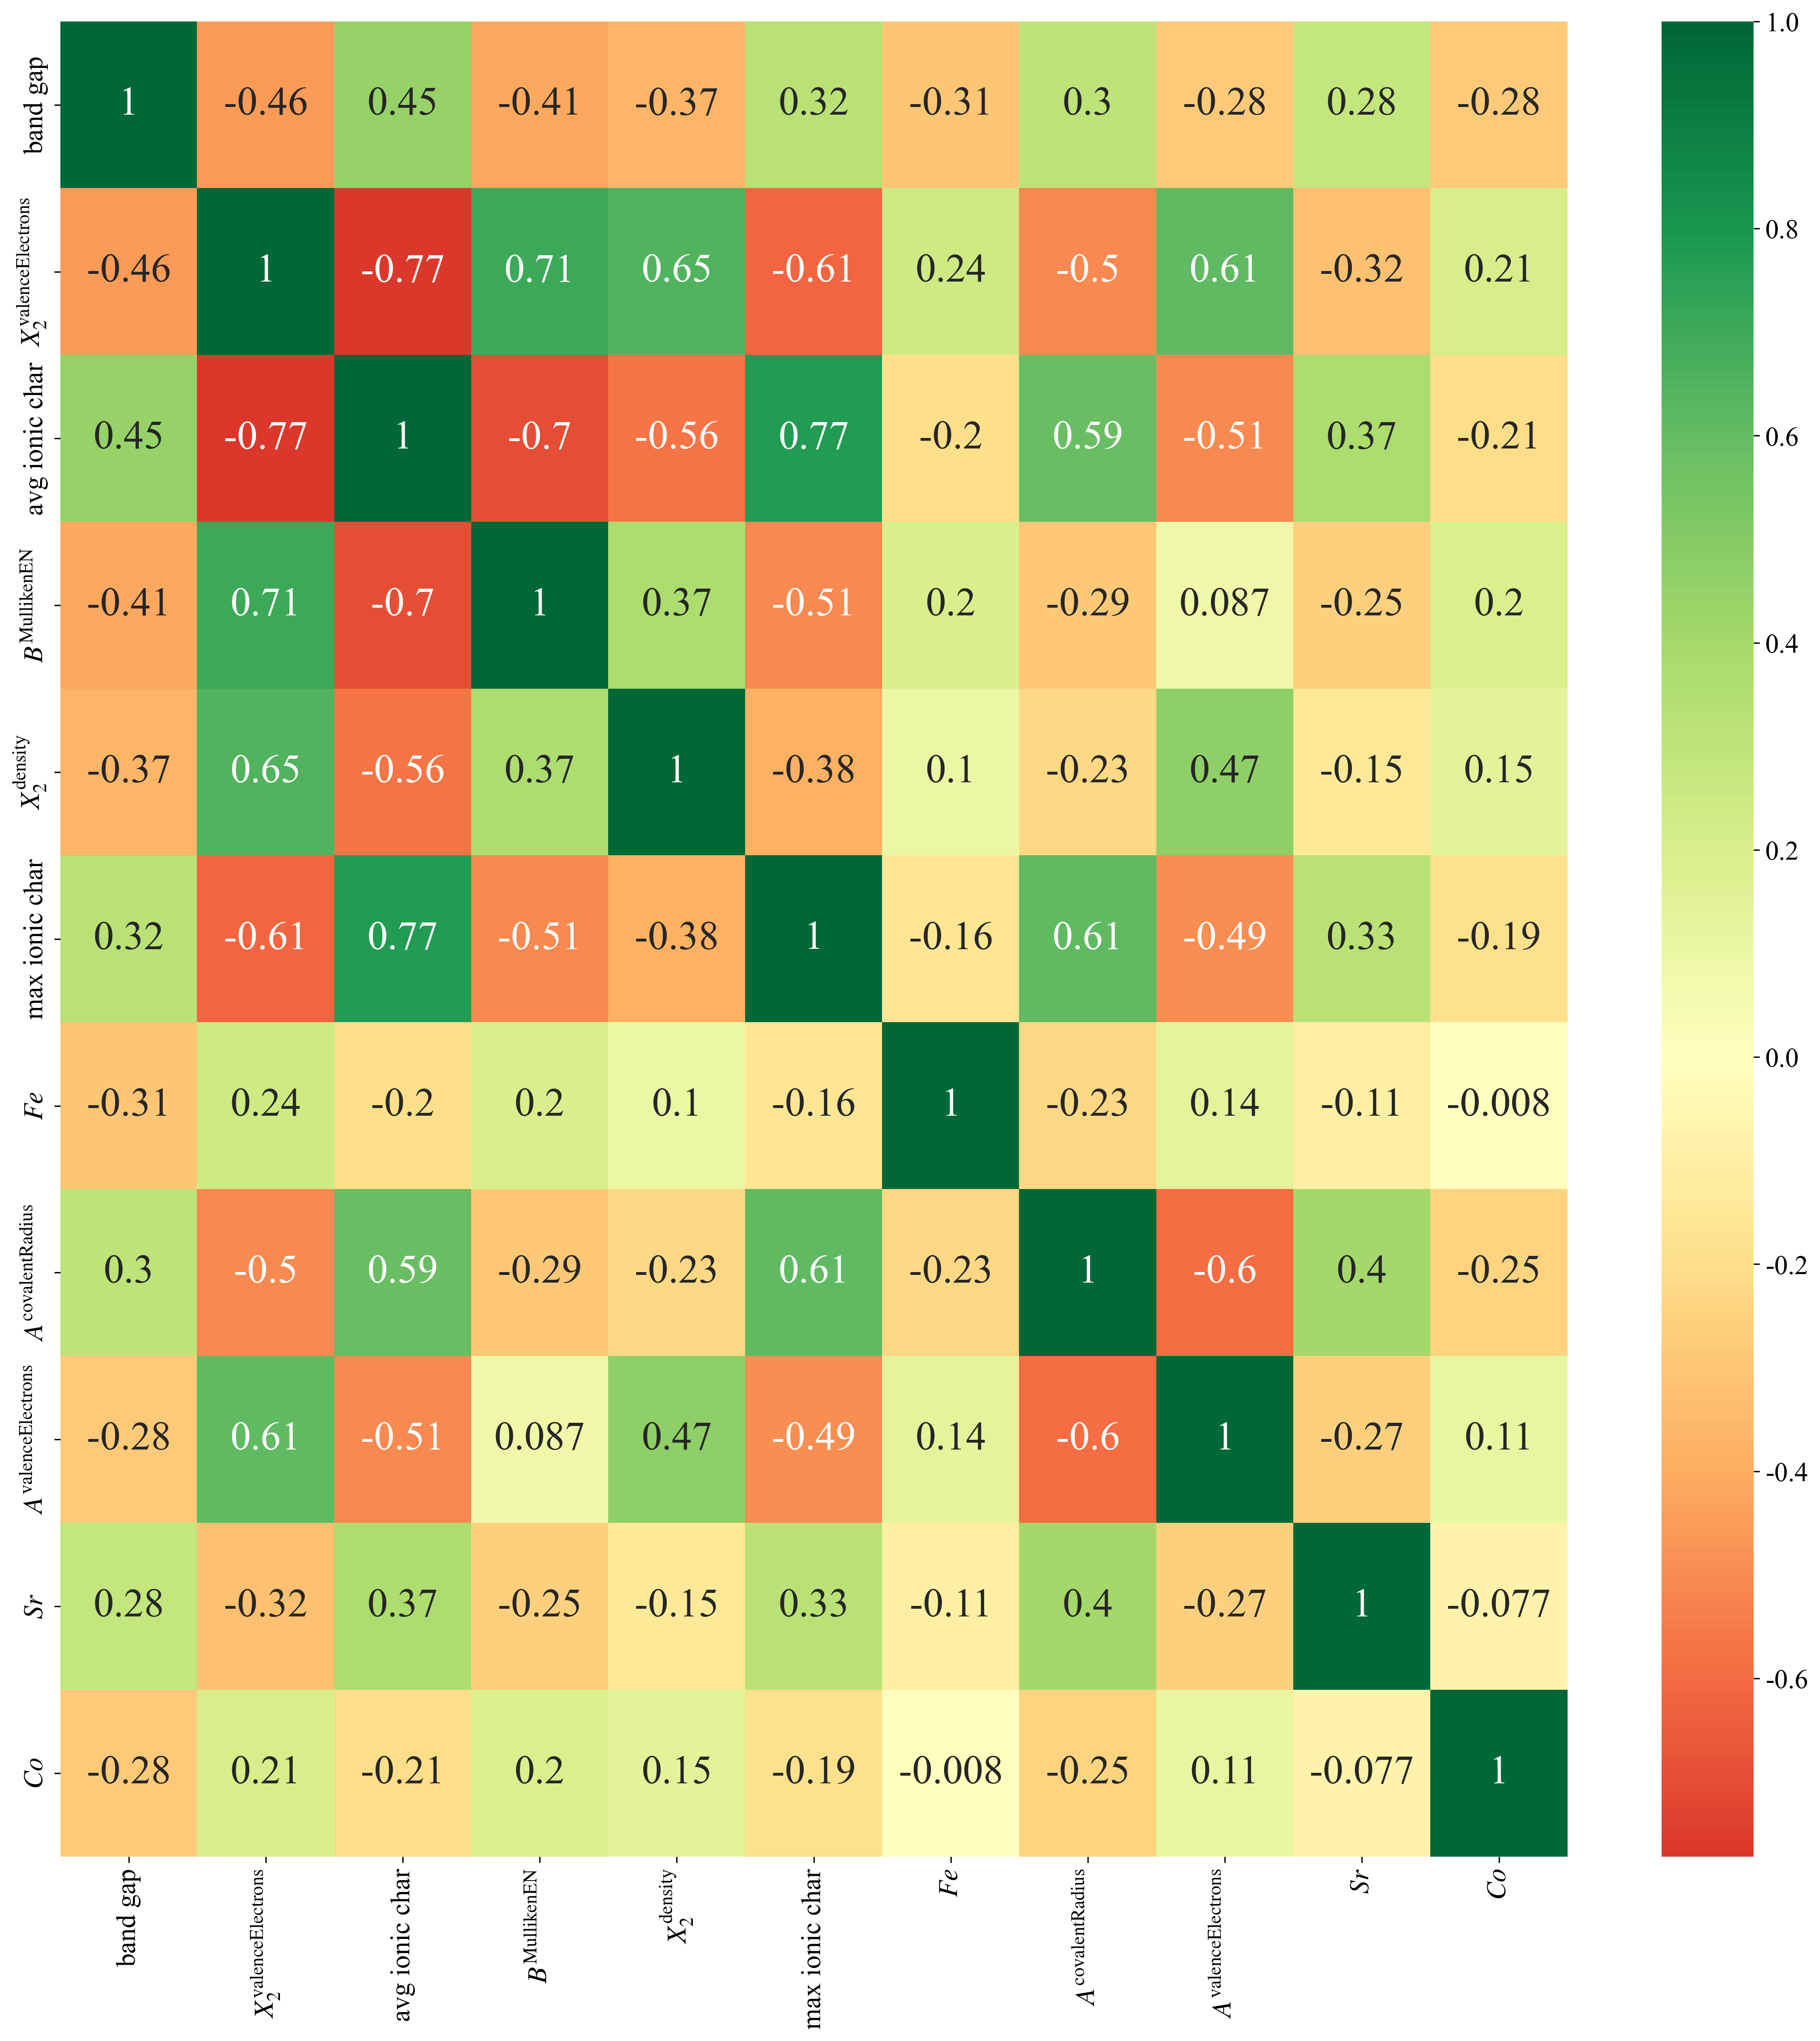

In [16]:
plt.figure(figsize=(20,20), dpi= 300)
corr = pd.concat([X_train,y_train],axis=1).corr(method='spearman' ,min_periods=1)
tmp = np.abs(corr['band gap'])
to_plot = tmp.sort_values(ascending=False)[0:11]
sns.heatmap(corr.loc[to_plot.index,to_plot.index], cmap='RdYlGn', center=0, annot=True)
plt.show()

In [17]:
from interpret import show
from interpret.perf import RegressionPerf
blackbox_model = RandomForestRegressor(n_jobs=-1,random_state=42)
blackbox_model.fit(X_train, y_train)
blackbox_perf = RegressionPerf(blackbox_model).explain_perf(X_test, y_test, name='Blackbox')
blackbox_perf.visualize()

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
y_pred = blackbox_model.predict(X_test)
print('Performance on the test set: MAE = %0.4f' % mean_absolute_error(y_test,y_pred))
print('Performance on the test set: RMSE = %0.4f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Performance on the test set: R2 SCORE = %0.4f' % r2_score(y_test,y_pred))

Performance on the test set: MAE = 0.3824
Performance on the test set: RMSE = 0.5624
Performance on the test set: R2 SCORE = 0.8228


In [19]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
y_pred = blackbox_model.predict(X_train)
print('Performance on the train set: MAE = %0.4f' % mean_absolute_error(y_train,y_pred))
print('Performance on the train set: RMSE = %0.4f' % np.sqrt(mean_squared_error(y_train, y_pred)))
print('Performance on the train set: R2 SCORE = %0.4f' % r2_score(y_train,y_pred))

Performance on the train set: MAE = 0.1428
Performance on the train set: RMSE = 0.2156
Performance on the train set: R2 SCORE = 0.9744


In [20]:
from interpret.blackbox import MorrisSensitivity

sensitivity = MorrisSensitivity(blackbox_model, X_train)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")

sensitivity_global.visualize()

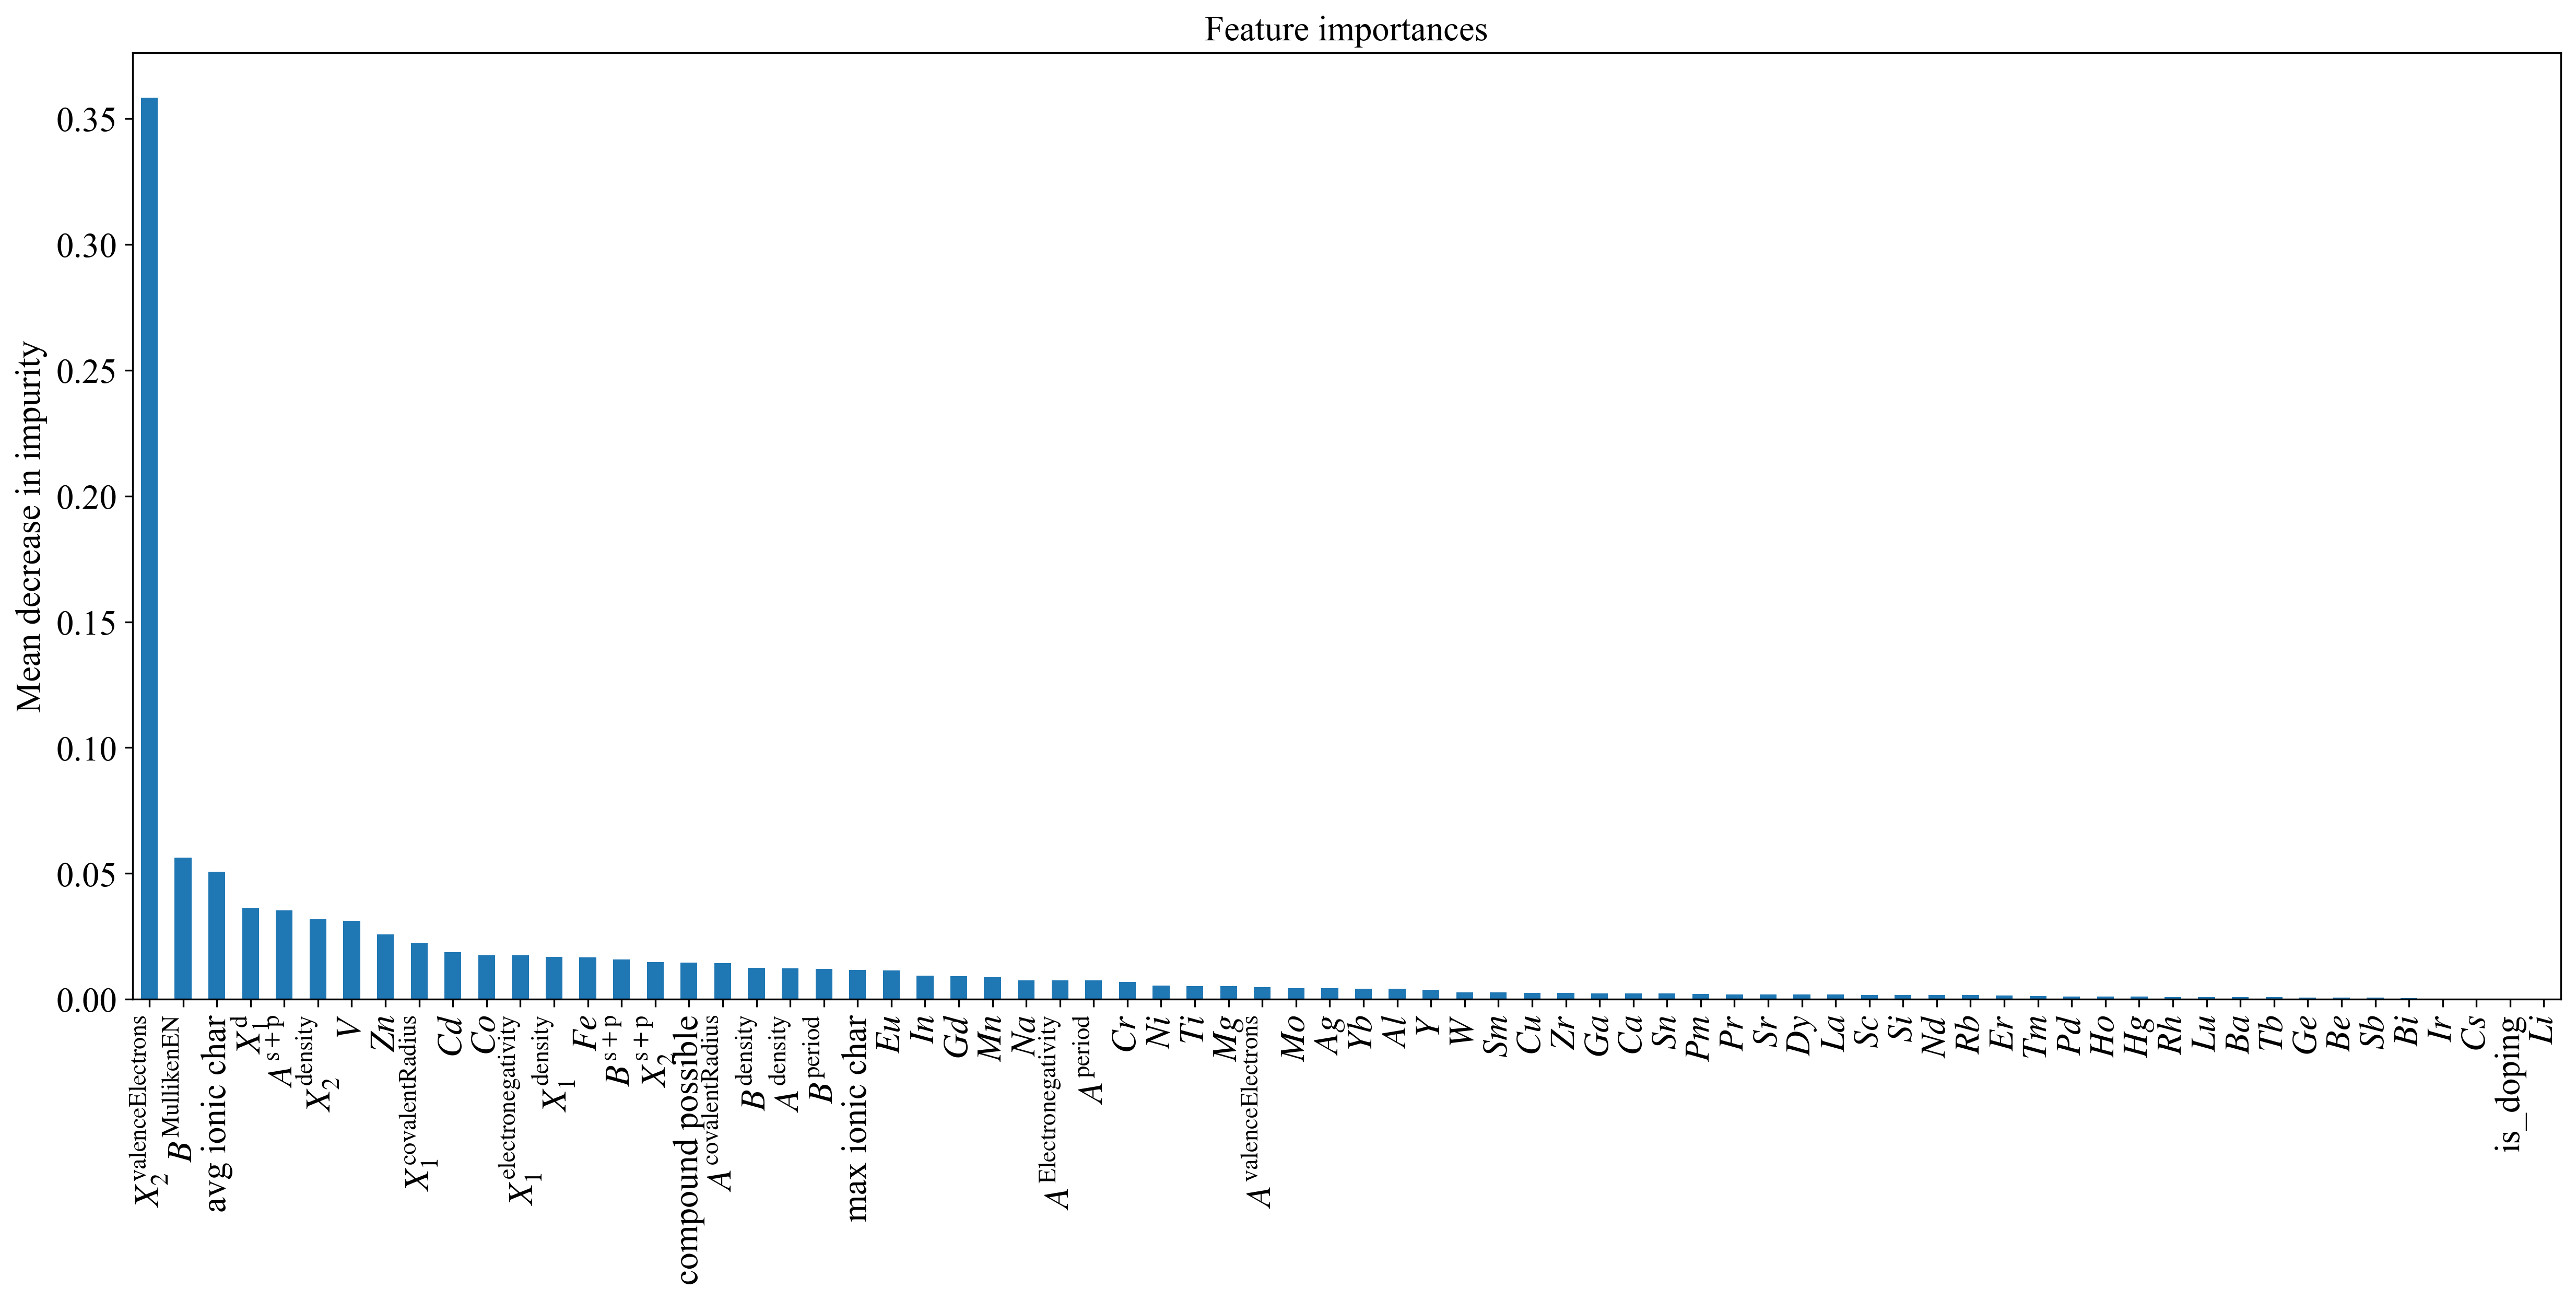

In [21]:
importances = blackbox_model.feature_importances_
# visualization
feat_with_importance = pd.Series(importances, X_train.columns)
feat_with_importance = feat_with_importance.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(20,8))
feat_with_importance.plot.bar(ax=ax )
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

Text(0, 0.5, 'band gap $(eV)$')

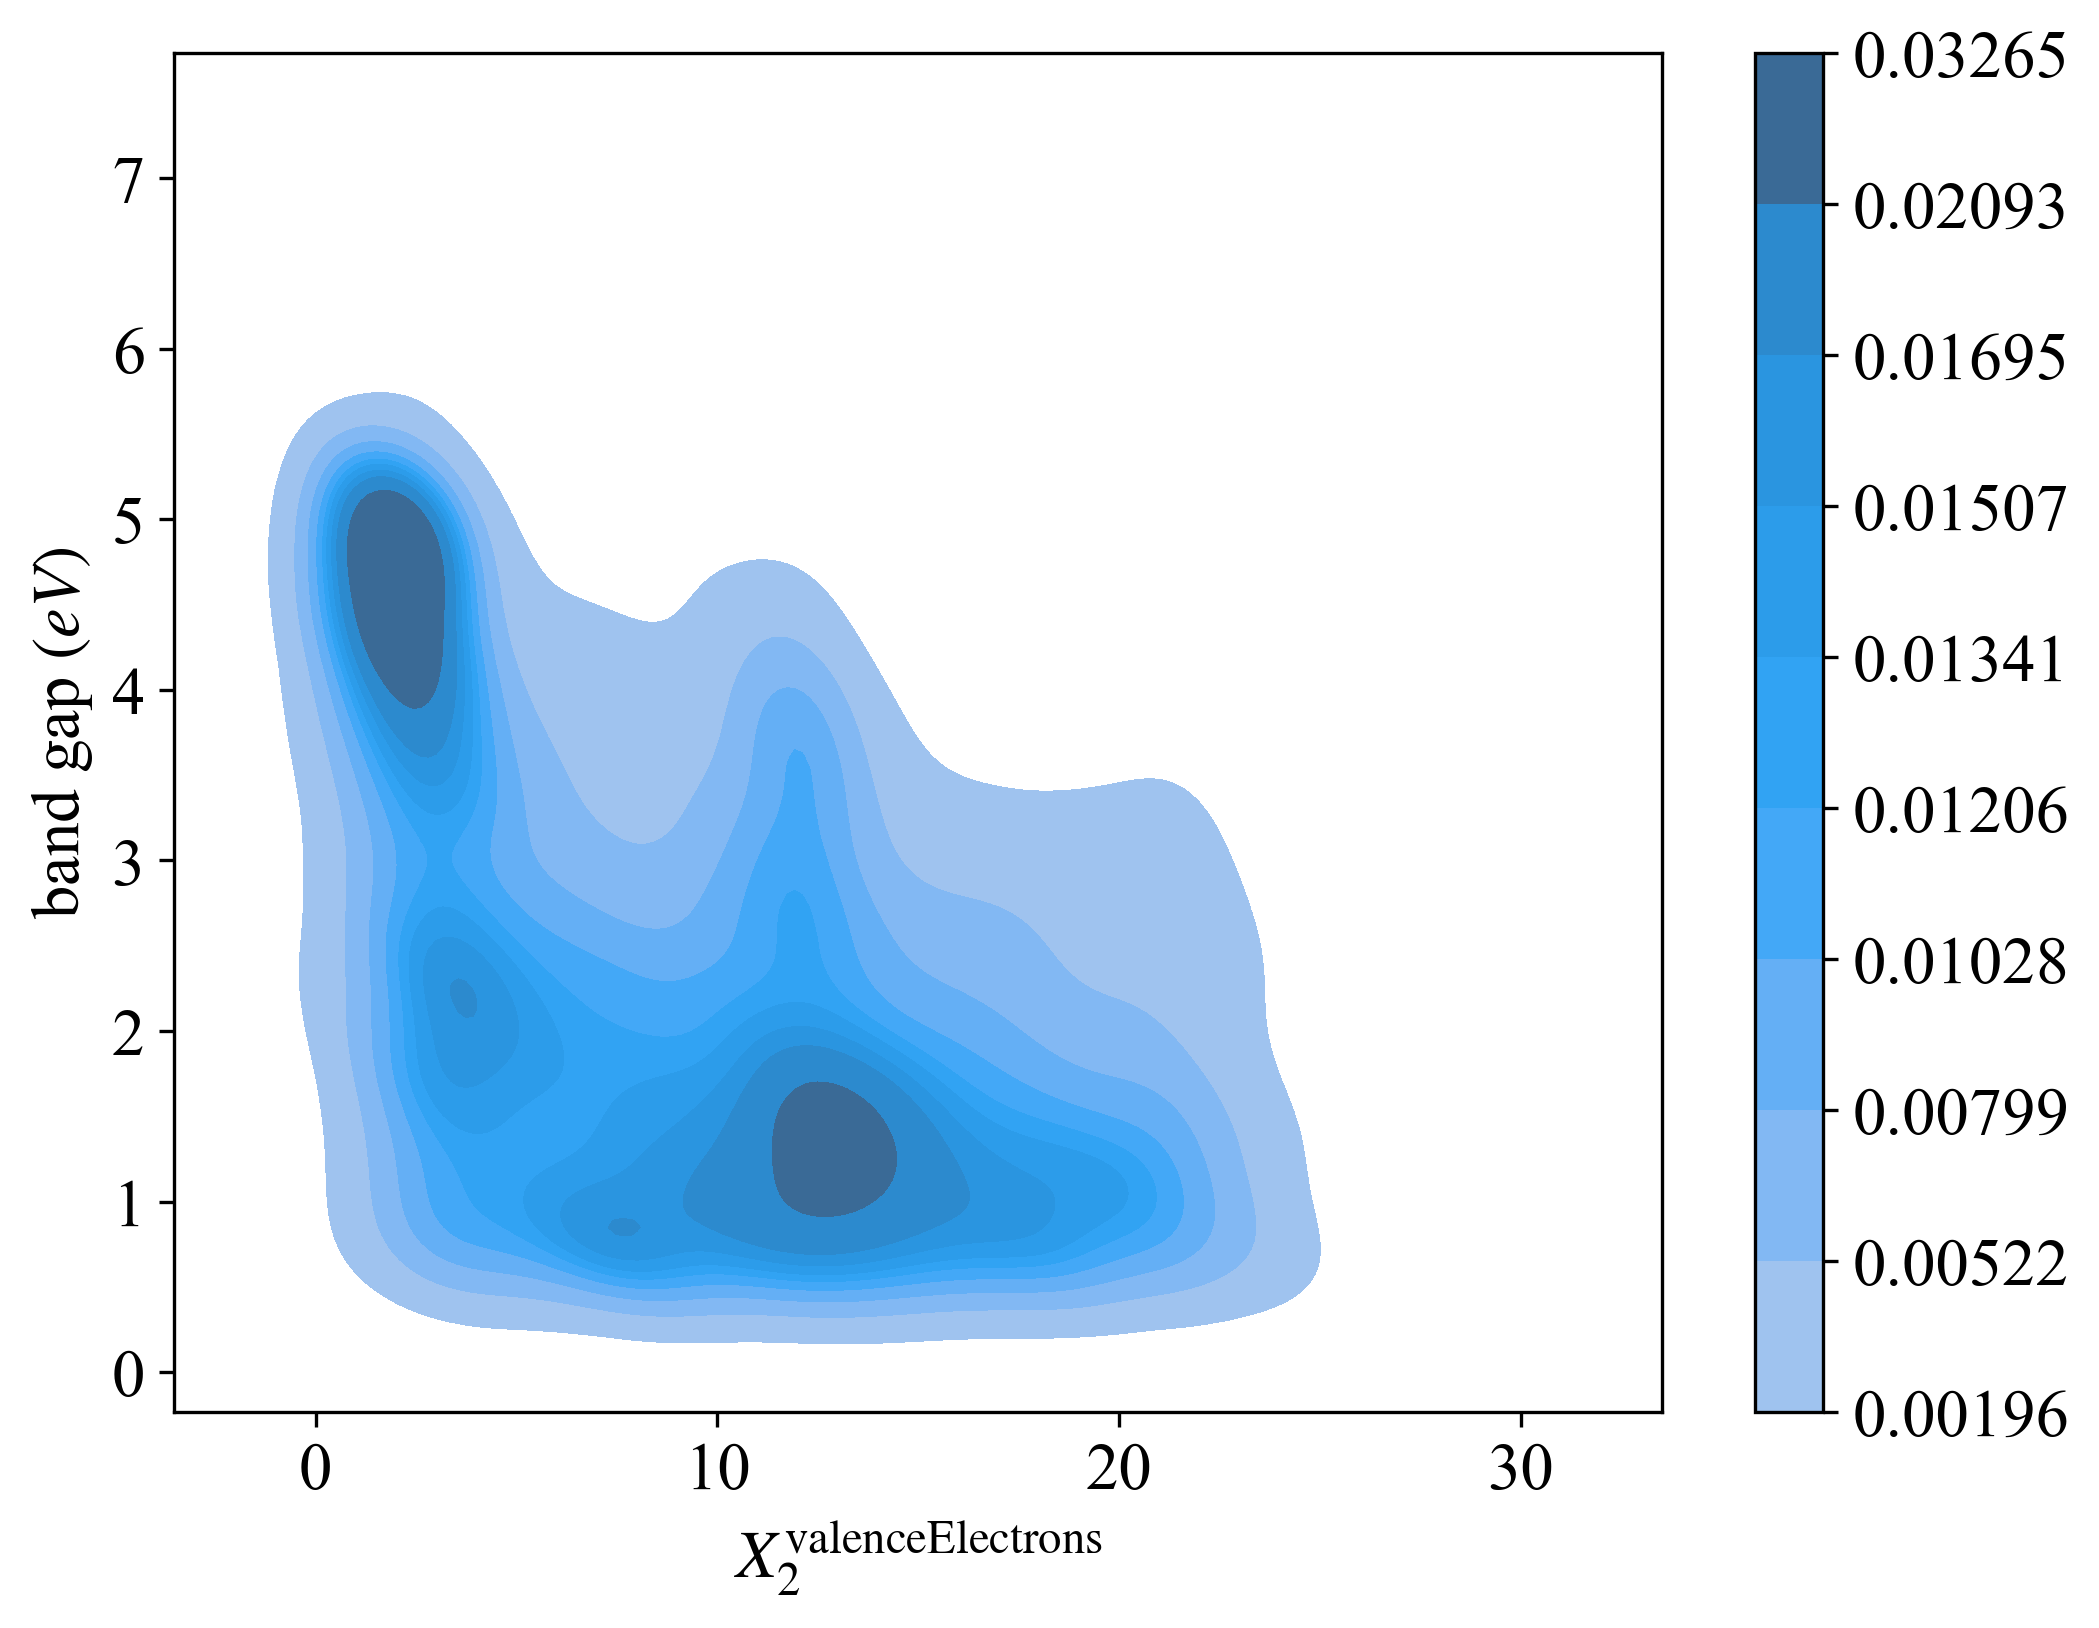

In [22]:
x=X_train[to_plot.index[1]]
sns.kdeplot(x=x, y=y_train, fill=True, cbar=True)
plt.ylabel('band gap '+r'$(eV)$')

Text(0, 0.5, 'band gap $(eV)$')

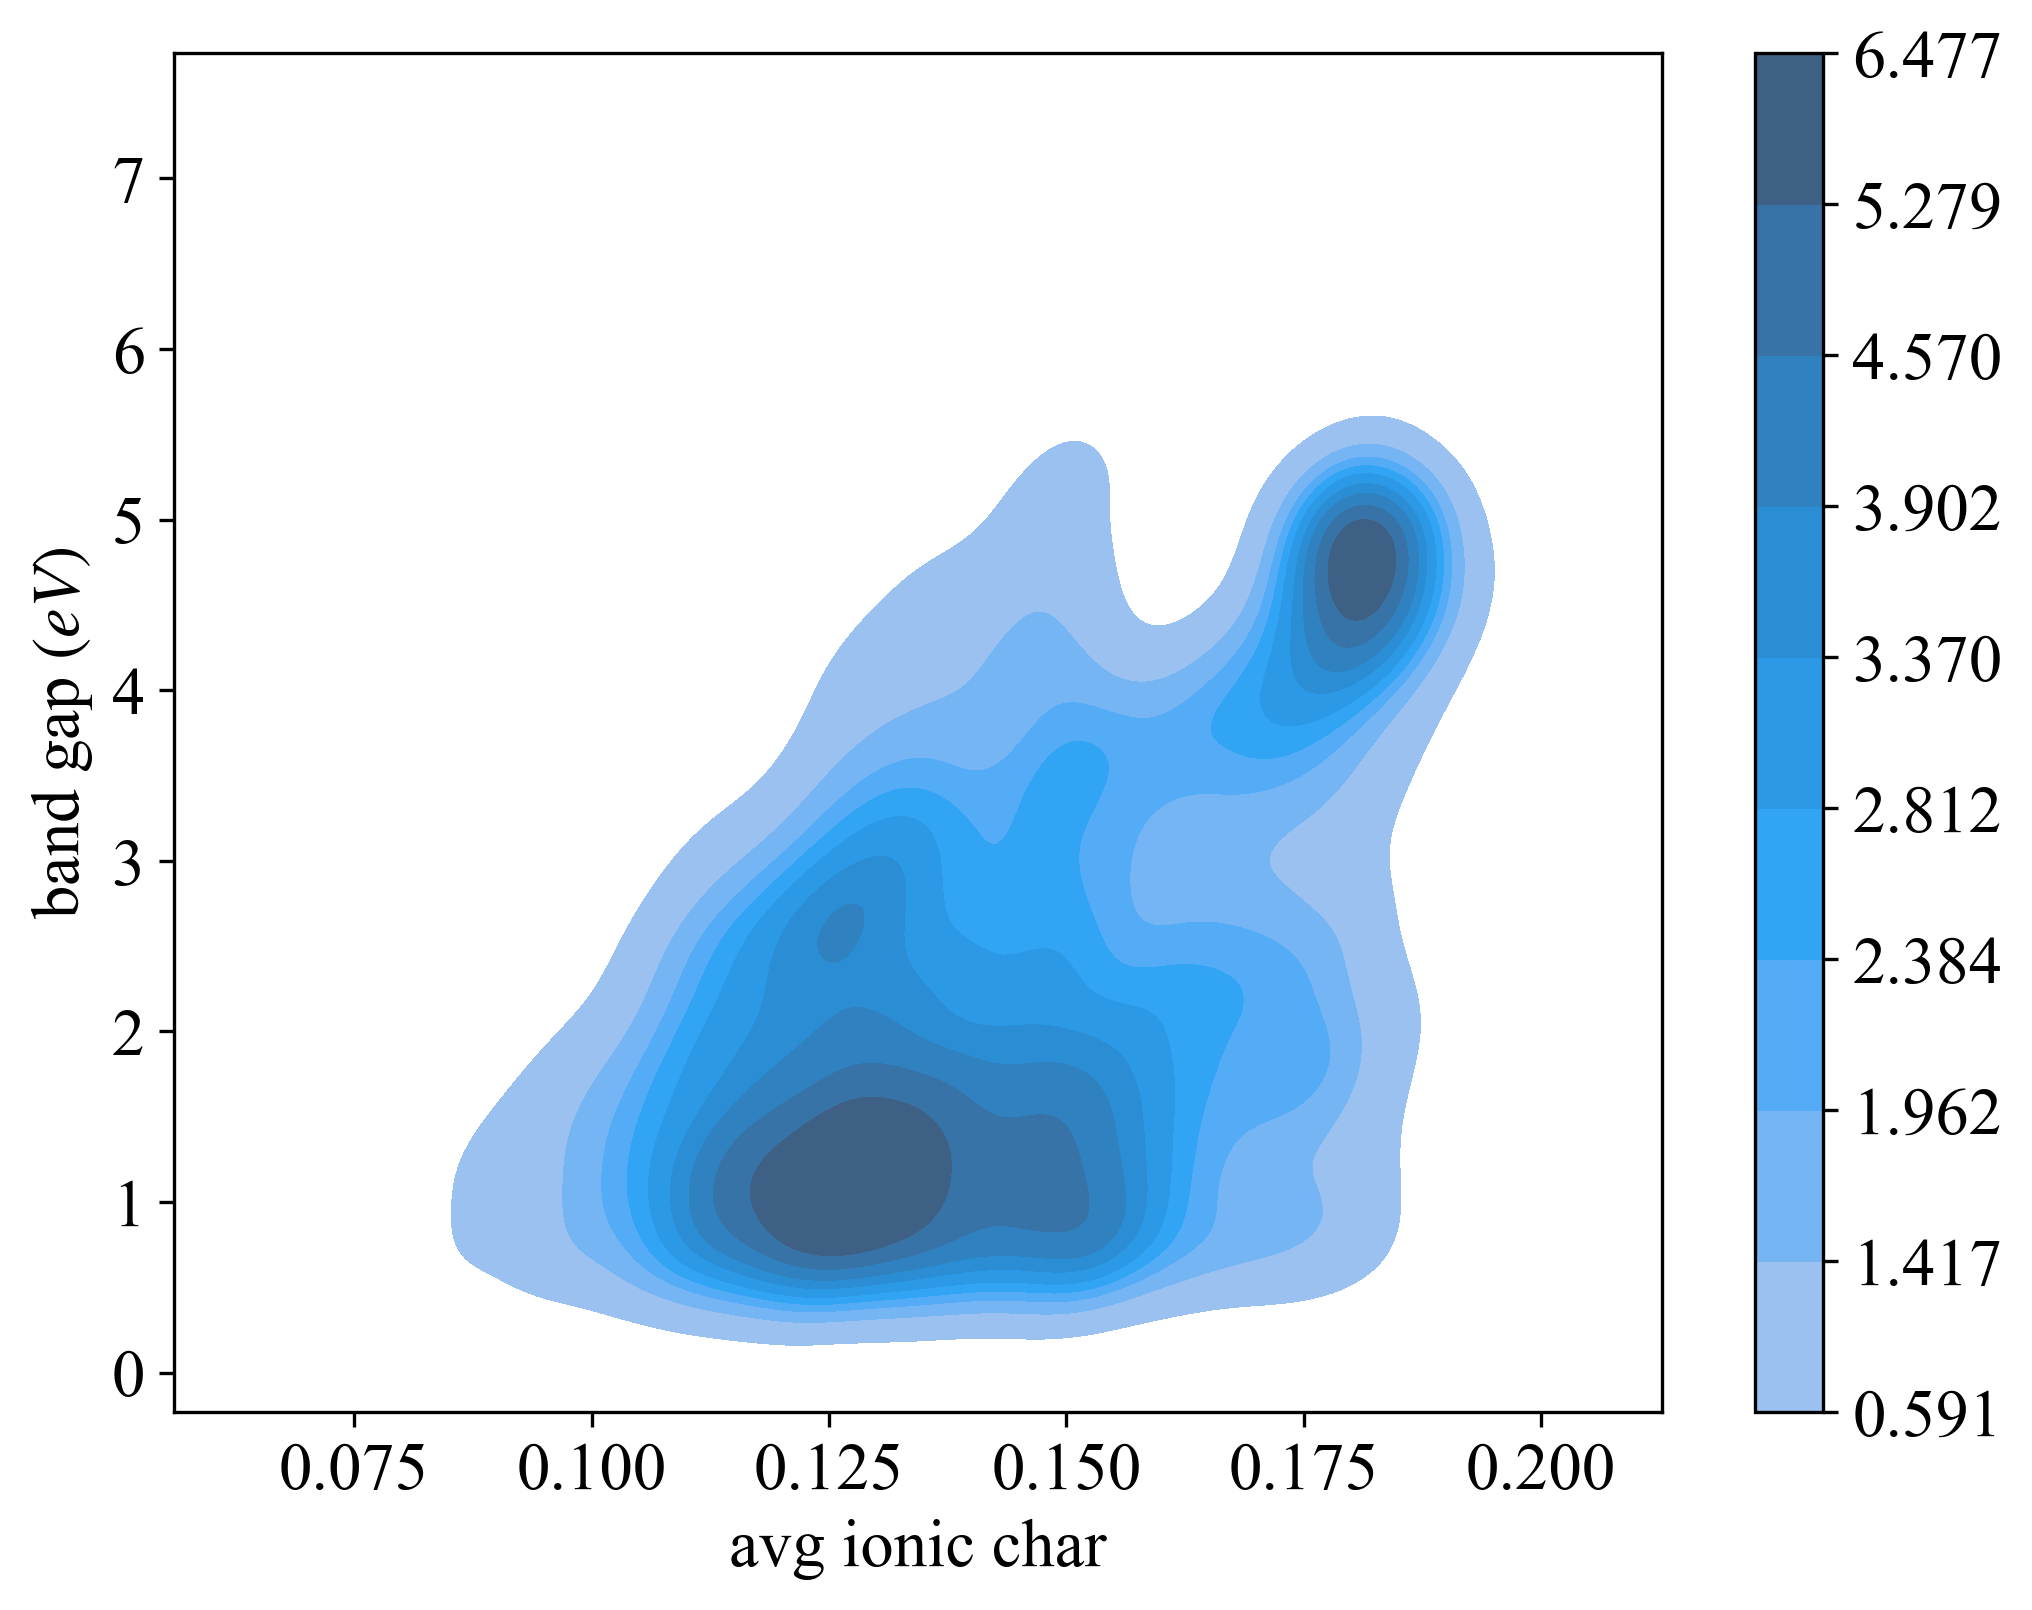

In [23]:
x=X_train[to_plot.index[2]]
sns.kdeplot(x=x, y=y_train, fill=True, cbar=True)
plt.ylabel('band gap '+r'$(eV)$')

Text(0, 0.5, 'band gap $(eV)$')

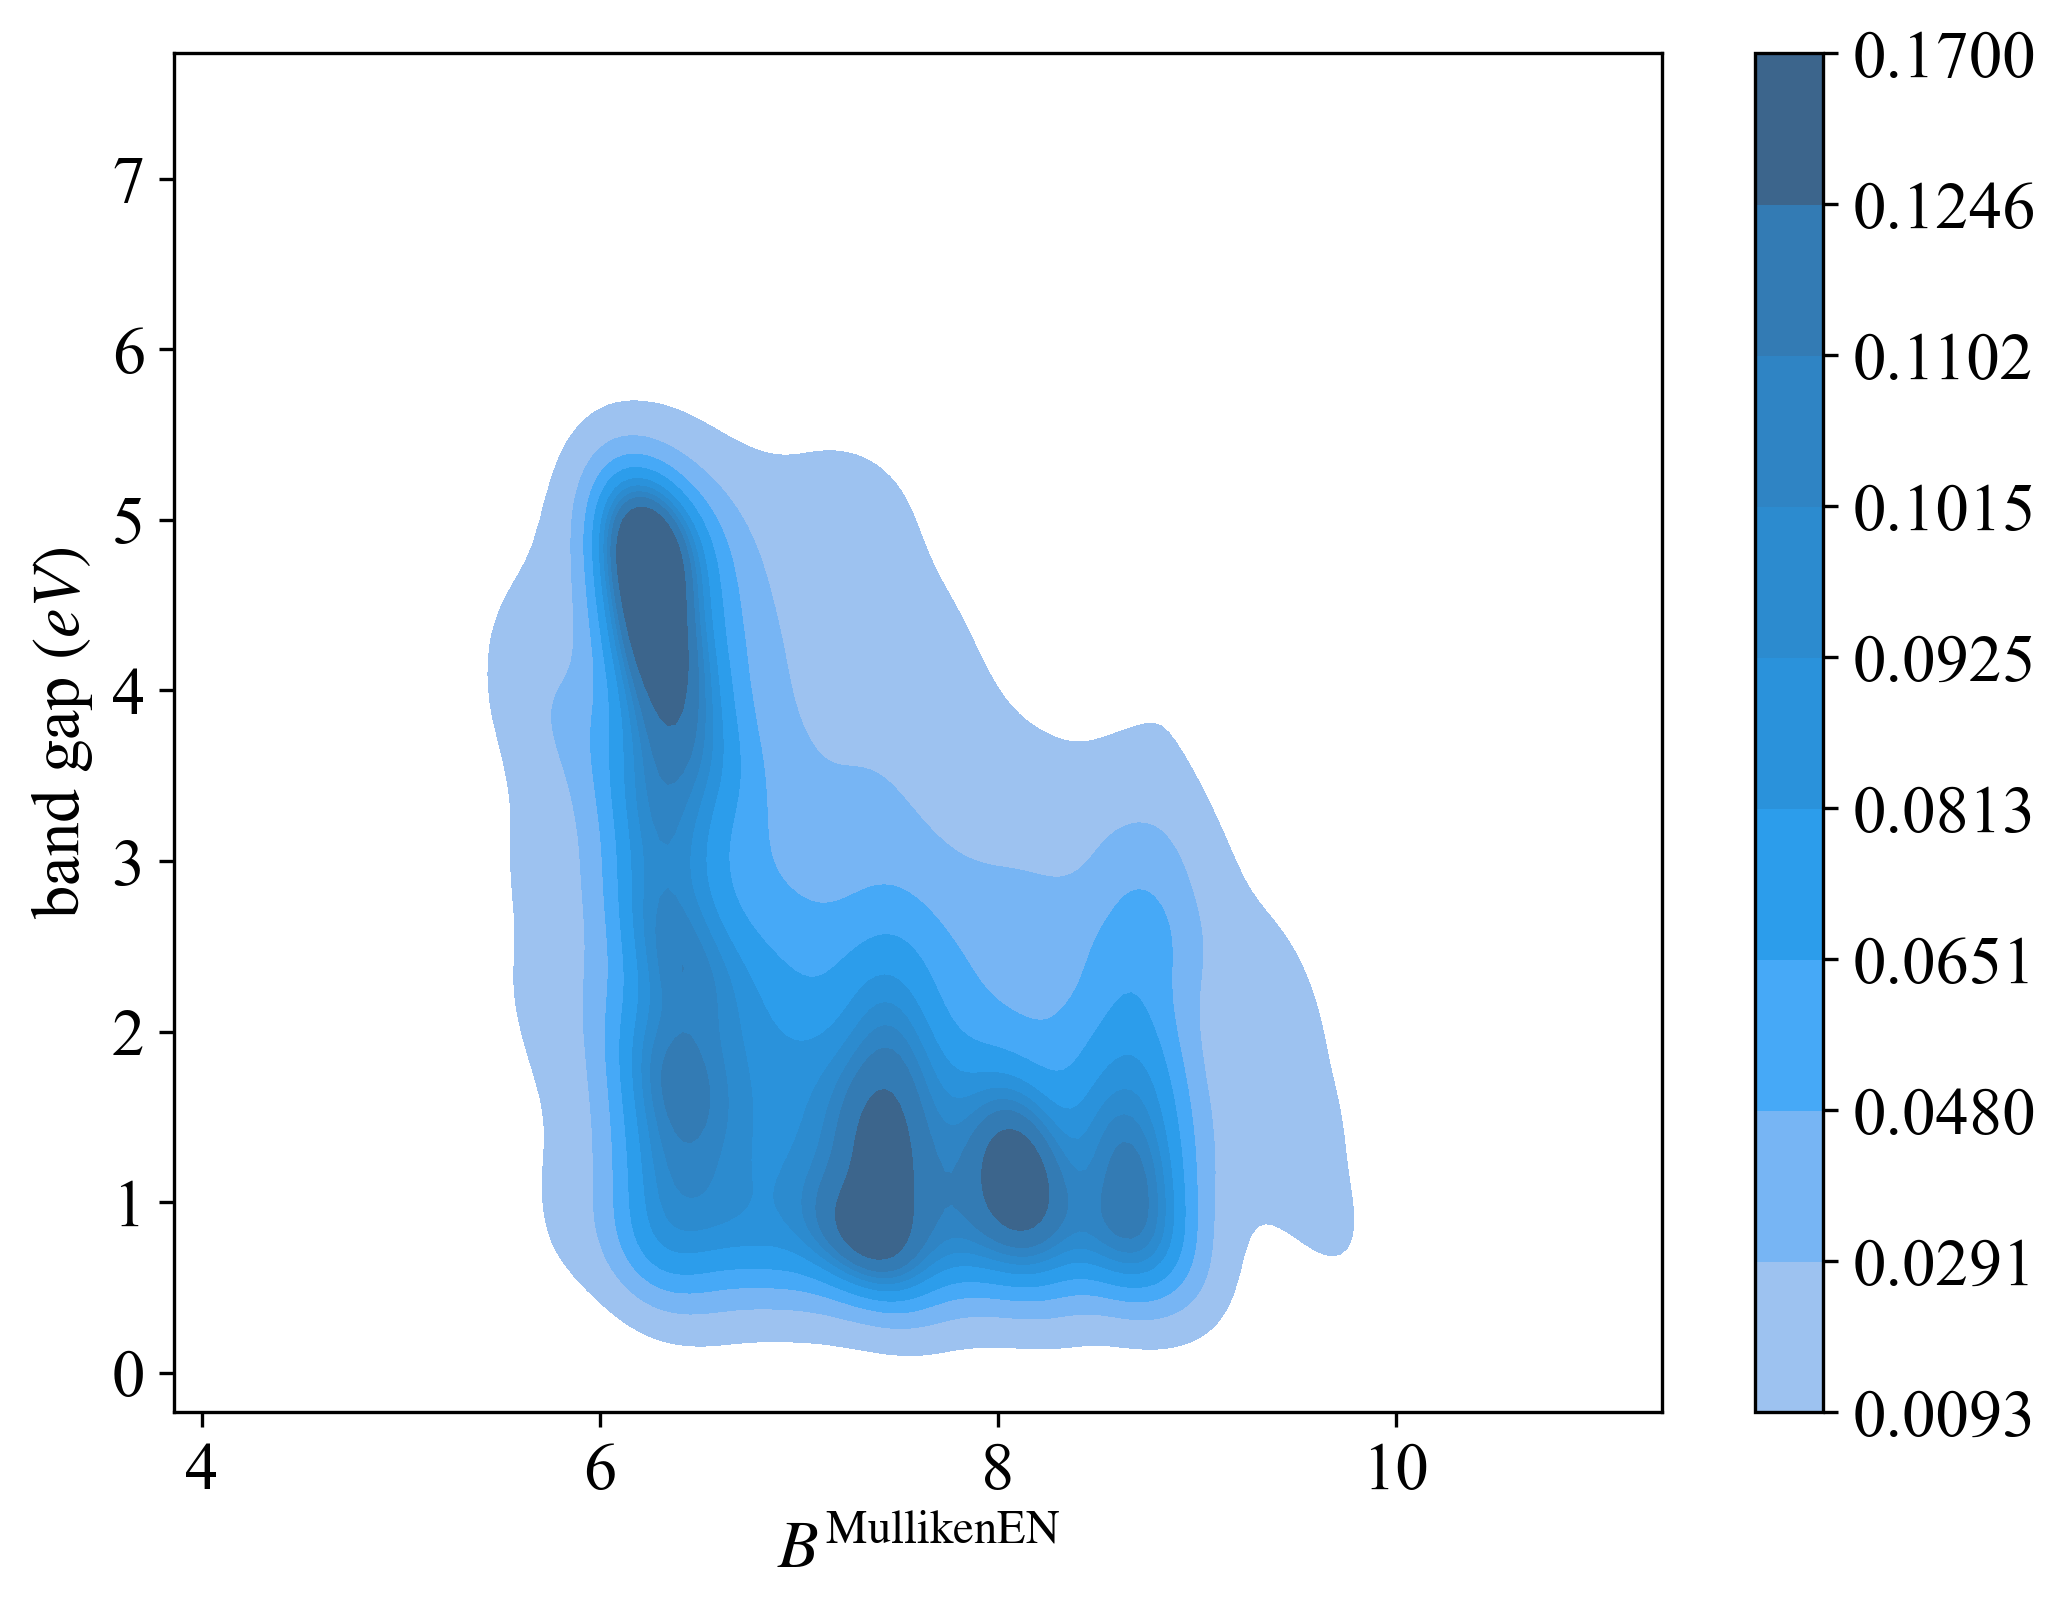

In [24]:
x=X_train[to_plot.index[3]]
sns.kdeplot(x=x, y=y_train, fill=True, cbar=True)
plt.ylabel('band gap '+r'$(eV)$')

Text(0, 0.5, 'band gap $(eV)$')

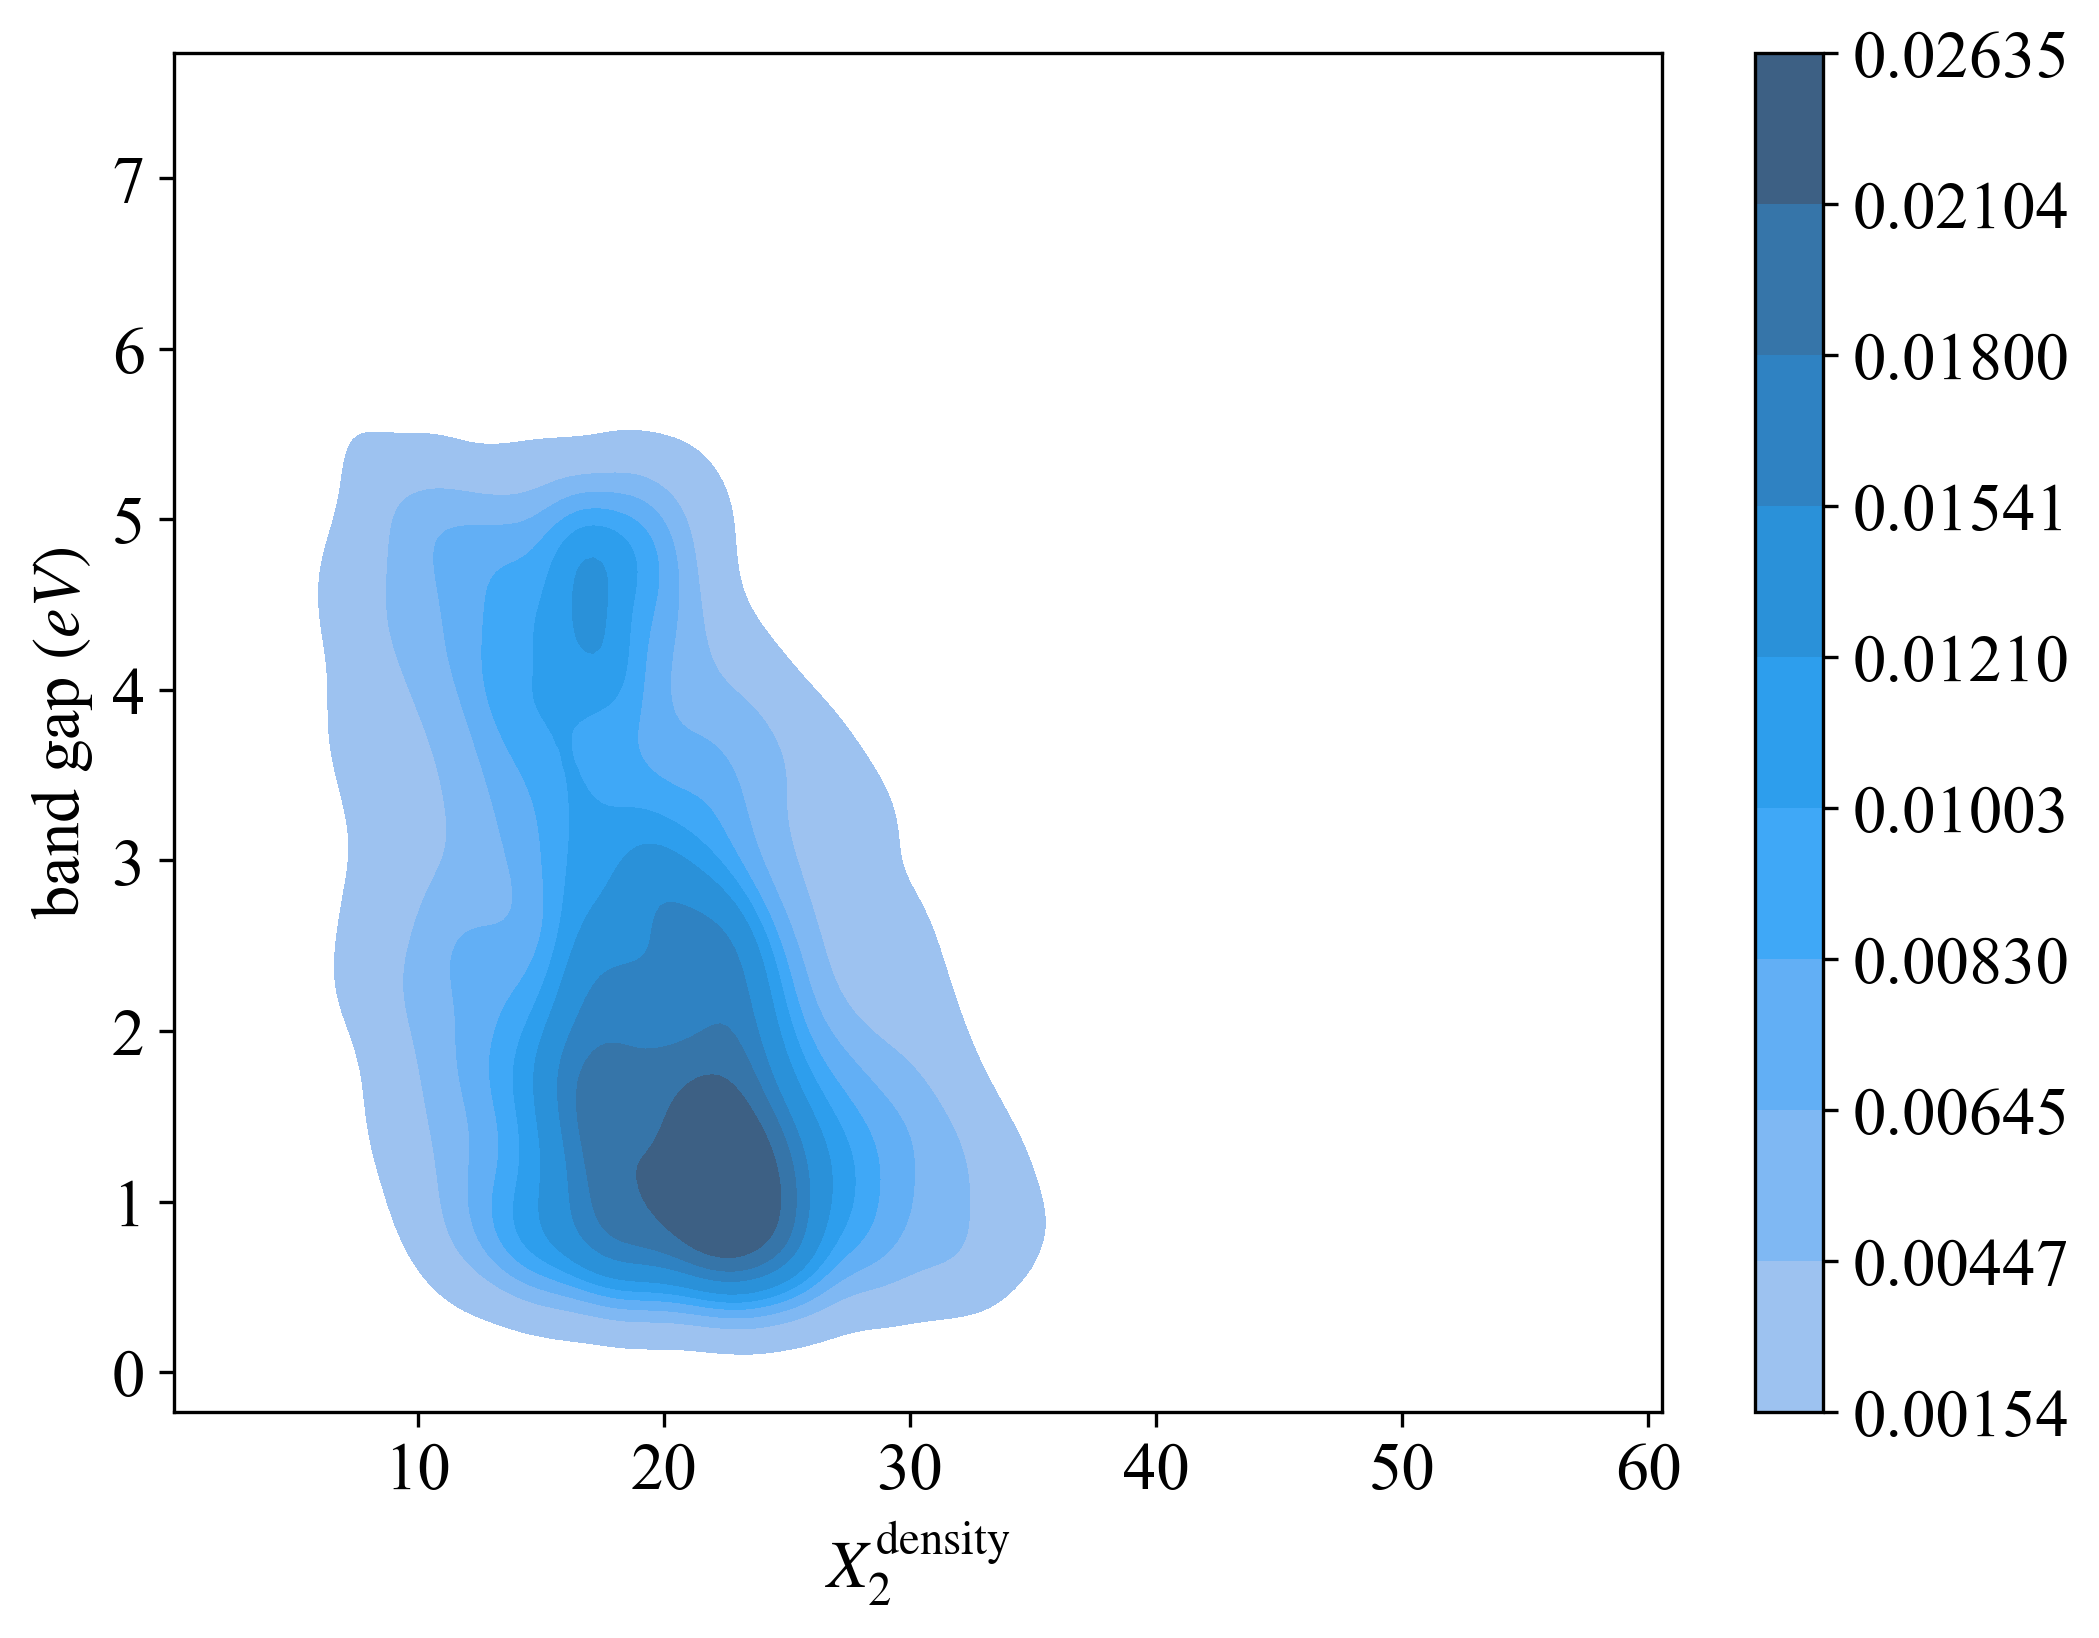

In [25]:
x=X_train[to_plot.index[4]]
sns.kdeplot(x=x, y=y_train, fill=True, cbar=True)
plt.ylabel('band gap '+r'$(eV)$')

In [26]:
import shap
explainer = shap.TreeExplainer(blackbox_model)
test = X_test.sample(2000)

In [ ]:
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values = shap_values, features=test)

In [ ]:
# 个体的shap图，用shap画一下ZnBi2O4个体的解释

In [28]:
X_train.loc[119]

$ A^{\mathrm{density}}$               7.130000
$ B^{\mathrm{density}}$              19.620000
$ A^{\mathrm{covalentRadius}}$      118.000000
$ A^{\mathrm{valenceElectrons}}$     12.000000
$ A^{\mathrm{period}}$                4.000000
                                       ...    
$Bi$                                  0.285714
compound possible                     1.000000
max ionic char                        0.551131
avg ionic char                        0.111009
is_doping                             0.000000
Name: 119, Length: 72, dtype: float64

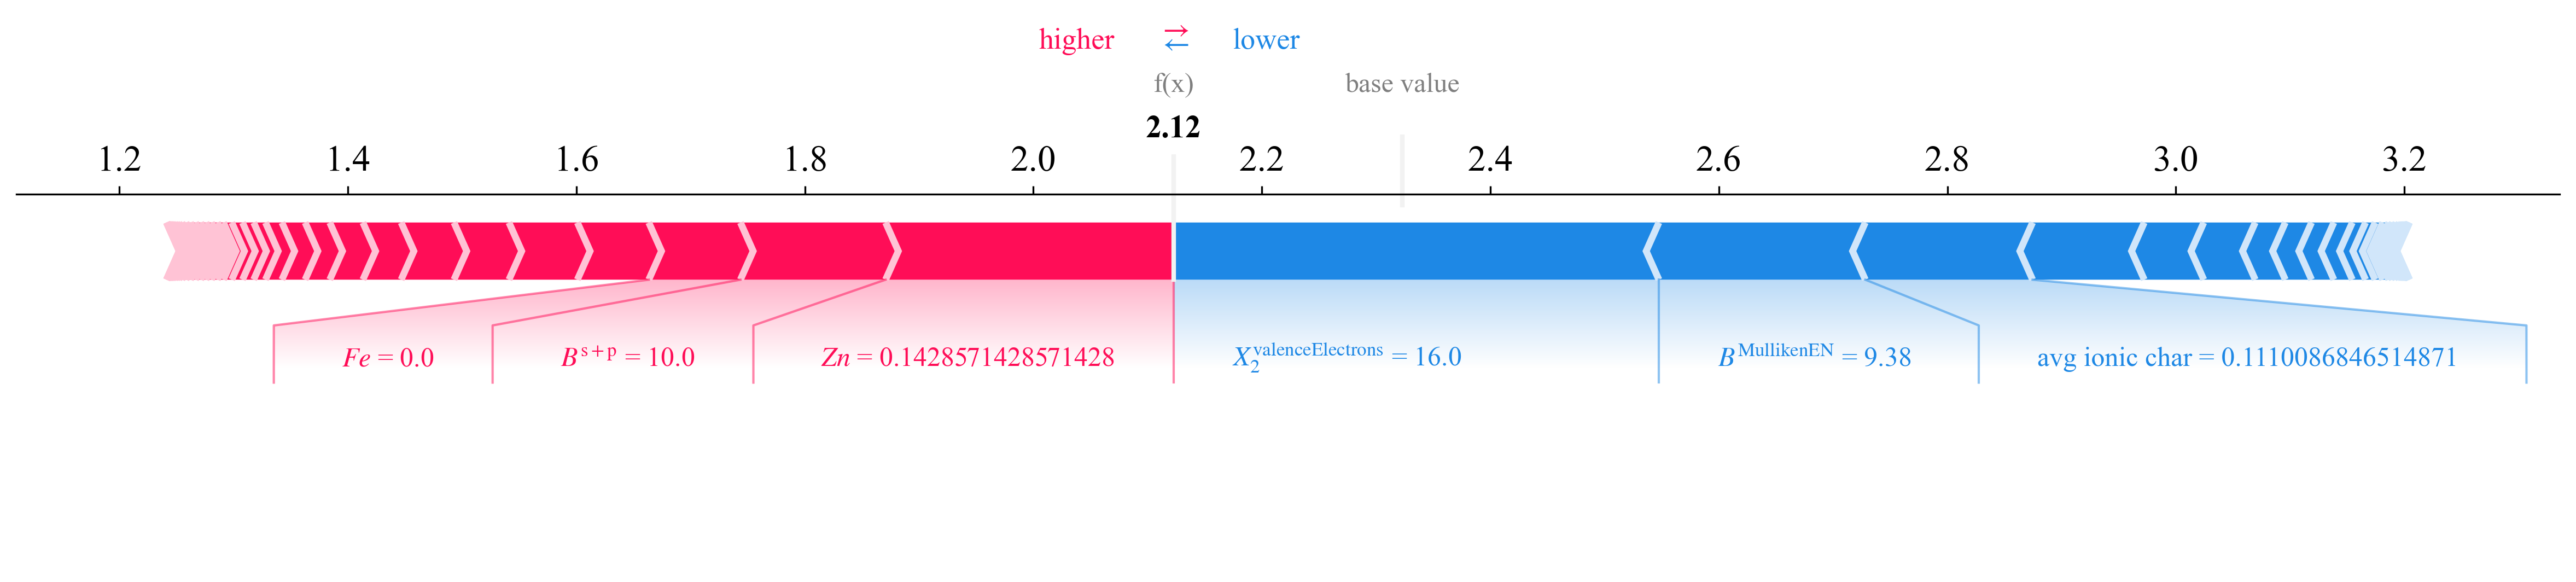

In [37]:
shap_values = explainer.shap_values(X_train.loc[119])
shap.force_plot(explainer.expected_value, shap_values, X_train.loc[119], matplotlib=True)

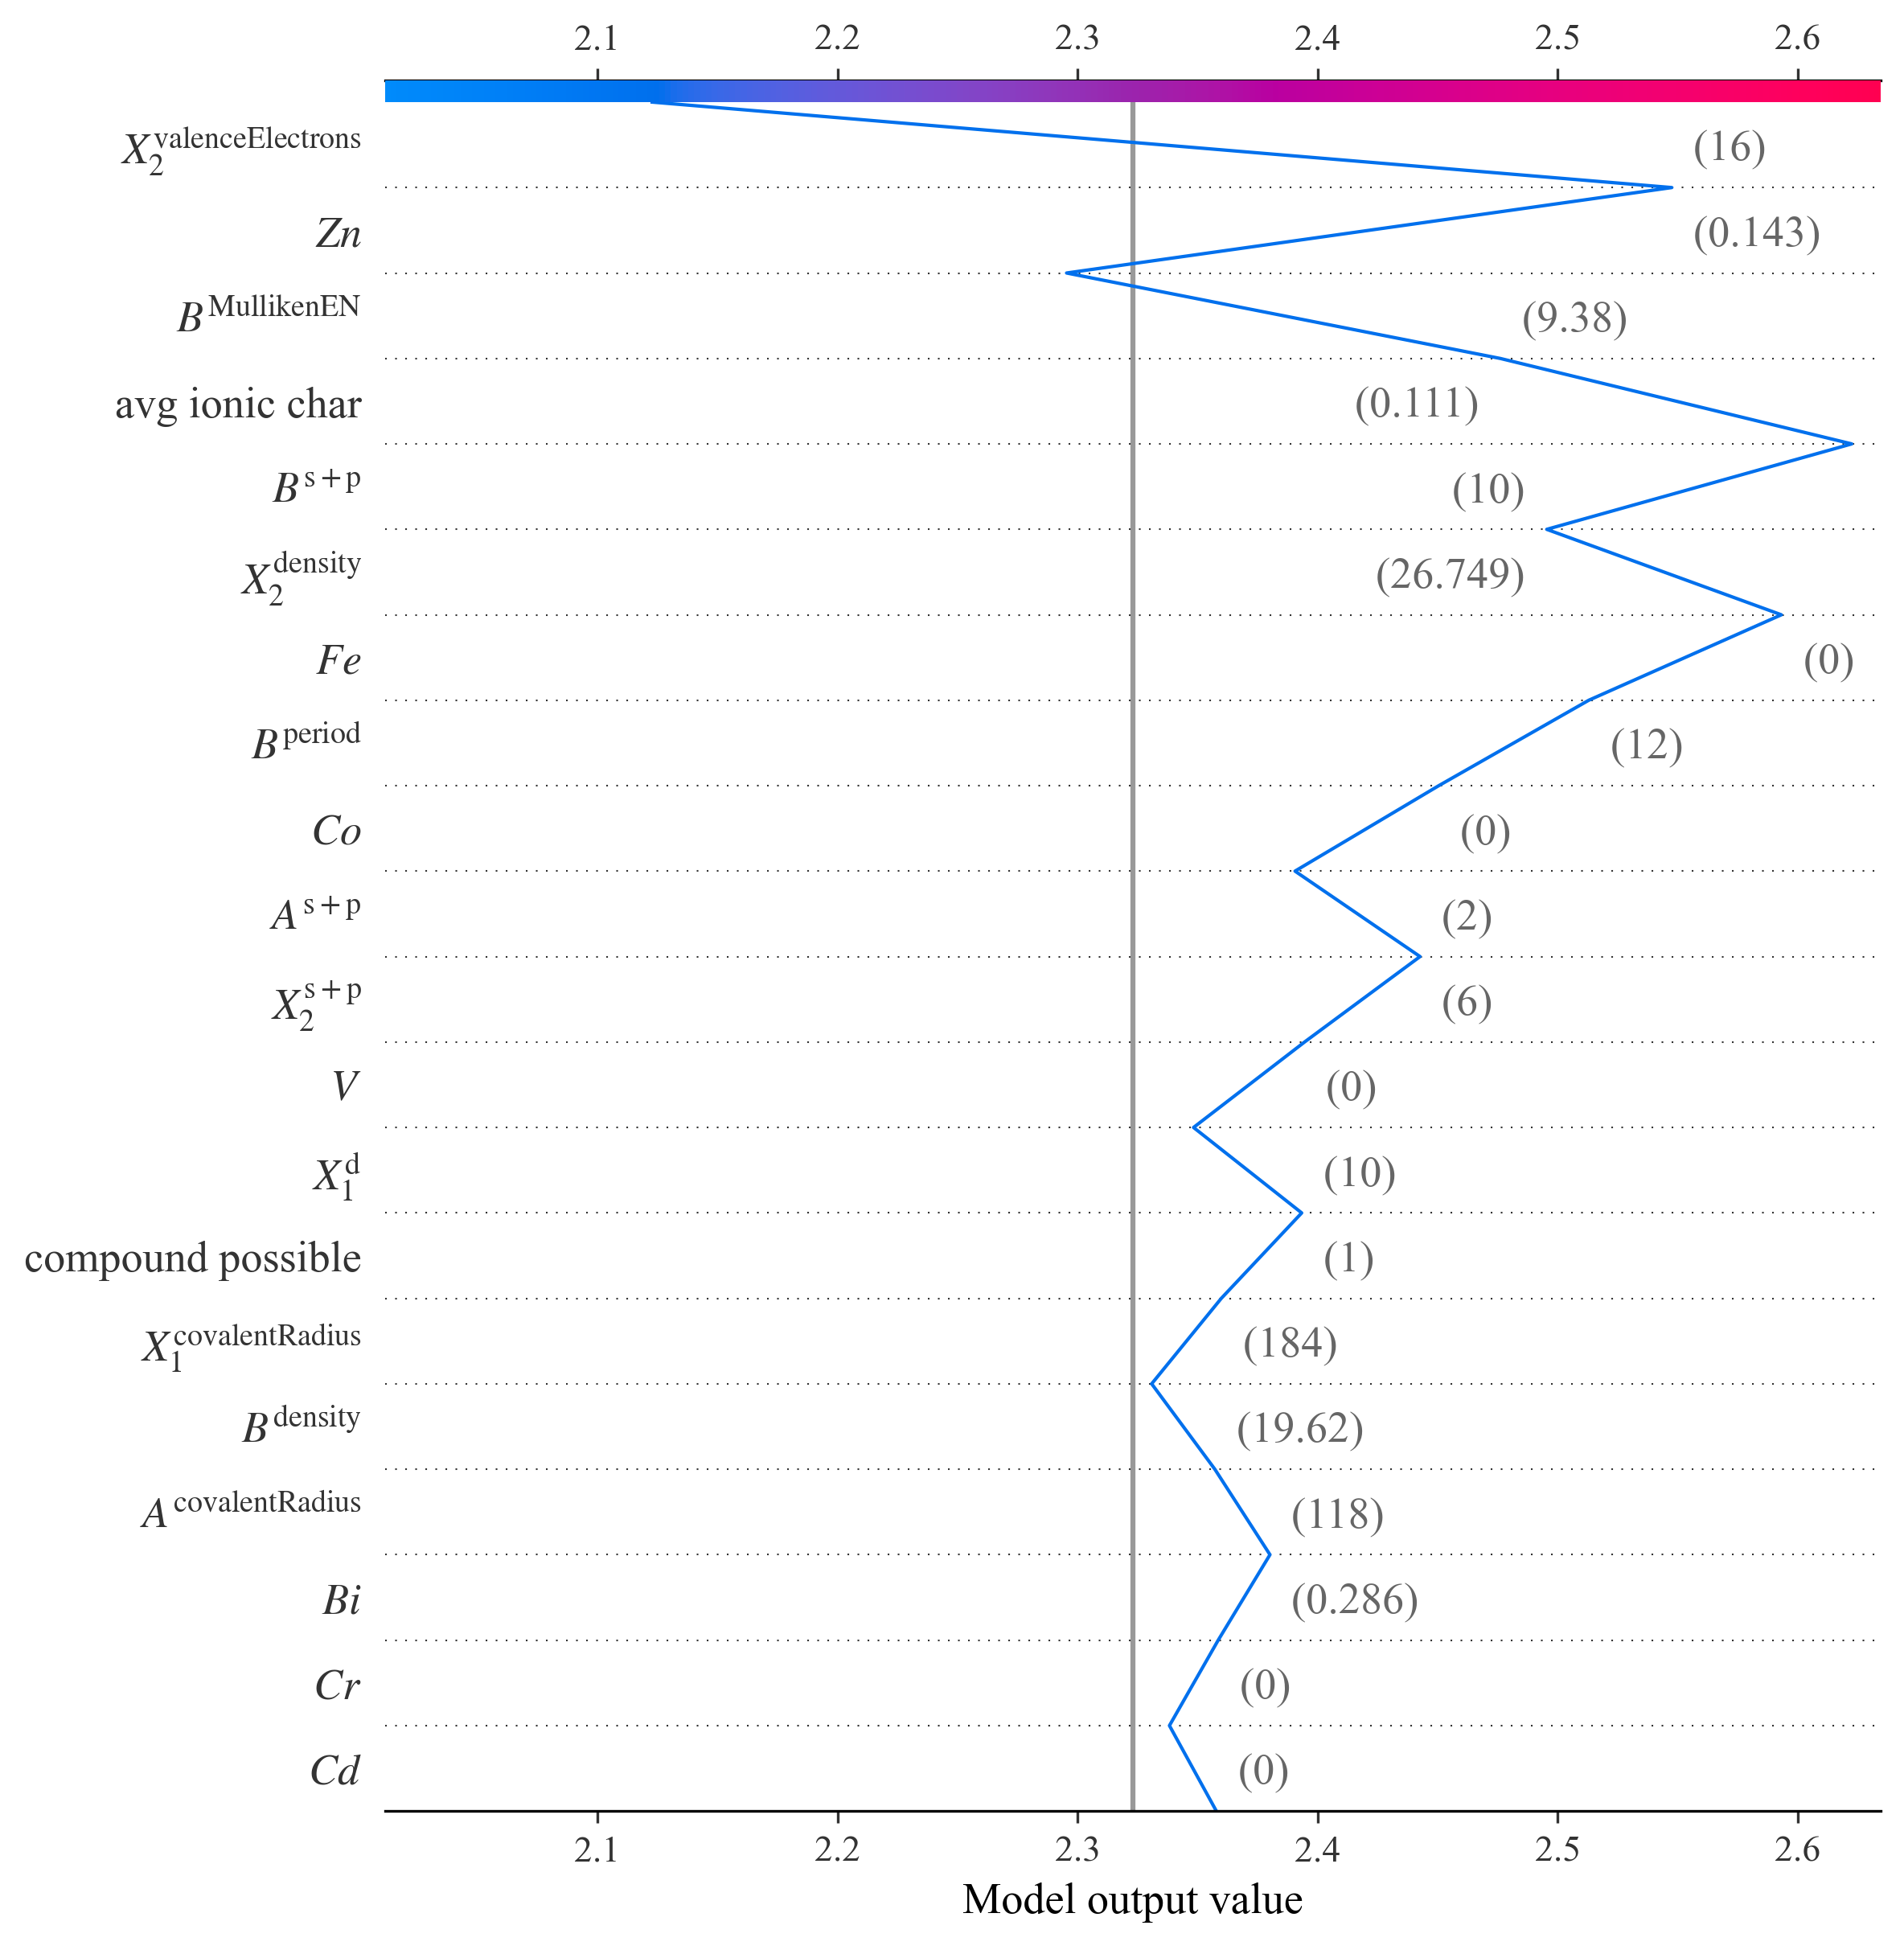

In [38]:
shap.decision_plot(explainer.expected_value, shap_values, X_train.loc[119])